This tutorial shows a regular PyTorch training program and a MONAI optimized training program, and compared the performance.  
Mainly includes:
1. AMP (Auto mixed precision).
2. CacheDataset for deterministic transforms.
3. Move data to GPU and cache, then execute random transforms on GPU.
4. multi-threads `ThreadDataLoader` is faster than PyTorch DataLoader in light-weight task.
5. Use MONAI `DiceCE` loss instead of regular `Dice` loss.
6. Analyzed training curve and tuned algorithm: Use `SGD` optimizer, different network parameters, etc.

With a V100 GPU and the target validation `mean dice = 0.94` of the `forground` channel only,  it's more than `100x` speedup compared with the Pytorch regular implementation when achieving the same metric. And every epoch is `20x` faster than regular training.

It's modified from the Spleen 3D segmentation tutorial notebook, the Spleen dataset can be downloaded from http://medicaldecathlon.com/.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/acceleration/fast_training_tutorial.ipynb)(* please note that the free GPU resource in Colab may be not as powerful as the V100 test results in this notebook: it may not support AMP and the GPU computation of transforms may be not faster than the CPU computation.)

## Setup environment

To support profiling, the following lines have been commented out. 

- To verify that you have key packages installed, uncomment the middle section (3 lines).
- If you are not interested in profiling (i.e., you will run this as a Jupyter notebook), uncomment the last line.

In [1]:
# these are commented out to ensure the converted python script runs smoothly

# !python3 -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
# !python3 -c "import matplotlib" || pip install -q matplotlib
# !python3 -c "import nvtx" || pip install -q nvtx

%matplotlib inline

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import math
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, SGD
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    Dataset,
    decollate_batch,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    Compose,
    CropForegroundd,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToDeviced,
    EnsureTyped,
    EnsureType,
)
from monai.utils import set_determinism

# for profiling
import nvtx
from monai.utils.nvtx import Range
import contextlib  # to improve code readability (combining training/validation loop with and without profiling)

print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.0
Numpy version: 1.22.3
Pytorch version: 1.12.0a0+bd13bc6
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.13.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.19.4
mlflow version: 1.26.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data & output directories

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

root dir is: /tmp/tmpv0msvmnr


By default, outputs will go to `outputs/`. 

You can run this tutorial twice, once with profiling and once without, and the outputs will not conflict with each other. 
- When profiling, the output is `outputs/output_base.nsys-rep`, which you can then visualize using the GUI of Nsight systems (a brief guide is provided in the "Profiling visualization" section below).
- When not profiling, the outputs are `outputs/loss_dice_comparison.png`, `outputs/metric_time_epochs.png`, and `outputs/total_epoch_time_comparison.png`.

We set up the tutorial such that figures are only generated when not profiling, but that does not have to be the case. In general, the figures make more sense when training is run for a higher number of epochs (e.g., hundreds), which is usually not the case when profiling.

In [4]:
# outputs

out_dir = "outputs/"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## Profiling

This section sets up profiling for this tutorial.

The number of epochs is automatically set based on whether profiling is being performed, but you can modify as needed.

- If you are not interested in profiling, please set `profiling = False` and move on.

- If you are profiling:

  - Because of the currently supported functionality of Nsight systems (`nsys`), profiling can only be performed from the terminal, and not from within this tutorial. For more information, including installation, refer to the [NVIDIA Nsight Systems page](https://developer.nvidia.com/nsight-systems).
  - Perform the following steps:
  
    1) Make sure `nsys` is installed;
    
    2) Set `profiling = True`;
    
    3) Make sure all lines in "Setup environment" (first code cell in this tutorial, above) are commented out;
    
    4) Save this notebook;
    
    5) Open the terminal and ensure that you are in the directory of this notebook, then run this command:
    `jupyter nbconvert fast_training_tutorial.ipynb --to python && nsys profile --output ./outputs/output_base --force-overwrite true --trace-fork-before-exec true python3 fast_training_tutorial.py ; rm fast_training_tutorial.py`
    
    This command converts the notebook to a Python script locally and runs `nsys`. The output file is `outputs/output_base.nsys-rep`, but you can modify `--output` to specify the desired location.

In [5]:
profiling = False

# if profiling = True, it is recommended to set max_epochs = 6 for faster prototyping
# to see the trend in training curve and dice results, set max_epochs to be larger (600)
# note that before optimization, training can be quite a bit slower
max_epochs = 6 if profiling else 600

# to improve readability


def range_func(x, y): return Range(x)(y) if profiling else y


no_profiling = contextlib.nullcontext()

## Download dataset

Downloads and extracts the Decathlon Spleen dataset.

In [6]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_root = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [01:00, 26.7MB/s]                                                                                    

2022-06-28 03:56:26,901 - INFO - Downloaded: /tmp/tmpv0msvmnr/Task09_Spleen.tar


2022-06-28 03:56:30,190 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2022-06-28 03:56:30,191 - INFO - Writing into directory: /tmp/tmpv0msvmnr.


## Set MSD Spleen dataset path

In [7]:
train_images = sorted(
    glob.glob(os.path.join(data_root, "imagesTr", "*.nii.gz"))
)
train_labels = sorted(
    glob.glob(os.path.join(data_root, "labelsTr", "*.nii.gz"))
)
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup transforms for training and validation

In [8]:
def transformations(fast=False, device='cuda:0'):
    train_transforms = [
        range_func("LoadImage", LoadImaged(keys=["image", "label"])),
        range_func("AddChannel", AddChanneld(keys=["image", "label"])),
        range_func("Orientation", Orientationd(keys=["image", "label"], axcodes="RAS")),
        range_func("Spacing", Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        )),
        range_func("ScaleIntensityRange",
                   ScaleIntensityRanged(
                       keys=["image"],
                       a_min=-57,
                       a_max=164,
                       b_min=0.0,
                       b_max=1.0,
                       clip=True,
                   )),
        range_func("CropForeground", CropForegroundd(keys=["image", "label"], source_key="image")),
        # pre-compute foreground and background indexes
        # and cache them to accelerate training
        range_func("Indexing", FgBgToIndicesd(
            keys="label",
            fg_postfix="_fg",
            bg_postfix="_bg",
            image_key="image",
        )),
        # change to execute transforms with Tensor data
        range_func("EnsureType", EnsureTyped(keys=["image", "label"])),
    ]

    if fast:
        # move the data to GPU and cache to avoid CPU -> GPU sync in every epoch
        train_transforms.append(range_func("ToDevice", ToDeviced(keys=["image", "label"], device=device)))

    train_transforms.append(
        # randomly crop out patch samples from big
        # image based on pos / neg ratio
        # the image centers of negative samples
        # must be in valid image area
        range_func("RandCrop", RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            fg_indices_key="label_fg",
            bg_indices_key="label_bg",
        )),
    )

    val_transforms = [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
    if fast:
        # move the data to GPU and cache to avoid CPU -> GPU sync in every epoch
        val_transforms.append(
            ToDeviced(keys=["image", "label"], device=device)
        )

    return Compose(train_transforms), Compose(val_transforms)

## Define the training progress
For a typical PyTorch regular training procedure, use regular `Dataset`, `DataLoader`, `Adam` optimizer and `Dice` loss to train the model.

For MONAI fast training progress, we mainly introduce the following features:
1. `AMP` (auto mixed precision): AMP is an important feature released in PyTorch v1.6, NVIDIA CUDA 11 added strong support for AMP and significantly improved training speed.
2. `CacheDataset`: Dataset with the cache mechanism that can load data and cache deterministic transforms' result during training.
3. `ToDeviced` transform: to move data to GPU and cache with `CacheDataset`, then execute random transforms on GPU directly, avoid CPU -> GPU sync in every epoch. Please note that not all the MONAI transforms support GPU operation so far, still working in progress.
4. `ThreadDataLoader`: uses multi-threads instead of multi-processing, faster than `DataLoader` in light-weight task as we already cached the results of most computation.
5. `DiceCE` loss function: computes Dice loss and Cross Entropy Loss, returns the weighted sum of these two losses.
6. Analyzed the training curve and tuned algorithm: Use `SGD` optimizer, different network parameters, etc.

(A note on code: to improve readability and support the profiling flag, we used the `with nvtx(...) if profiling else no_profiling` context pattern, where `no_profiling` is a null context from Python's native `contextlib` with no effect on the code. An acknowledgement is provided here[<sup id="fn1-back">1</sup>](#fn1).)

In [31]:
def train_process(fast=False):
    learning_rate = 2e-4
    val_interval = 5  # do validation for every epoch

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        raise RuntimeError('this tutorial is intended for GPU, but no CUDA device is available')

    train_trans, val_trans = transformations(fast=fast, device=device)
    # set CacheDataset, ThreadDataLoader and DiceCE loss for MONAI fast training
    if fast:
        # as `RandCropByPosNegLabeld` crops from the cached content and `deepcopy`
        # the crop area instead of modifying the cached value, we can set `copy_cache=False`
        # to avoid unnecessary deepcopy of cached content in `CacheDataset`
        train_ds = CacheDataset(
            data=train_files,
            transform=train_trans,
            cache_rate=1.0,
            num_workers=8,
            copy_cache=False,
        )
        val_ds = CacheDataset(
            data=val_files, transform=val_trans, cache_rate=1.0, num_workers=5, copy_cache=False
        )
        # disable multi-workers because `ThreadDataLoader` works with multi-threads
        train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=4, shuffle=True)
        val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

        loss_function = DiceCELoss(
            include_background=False,
            to_onehot_y=True,
            softmax=True,
            squared_pred=True,
            batch=True,
            smooth_nr=0.00001,
            smooth_dr=0.00001,
            lambda_dice=0.5,
            lambda_ce=0.5,
        )
        model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(32, 64, 128, 256, 512),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.instance,
            kernel_size=3,
            up_kernel_size=3,
            act=Act.PRELU,
            dropout=0.2,
            bias=True,
            dimensions=None,
        ).to(device)
    else:
        train_ds = Dataset(data=train_files, transform=train_trans)
        val_ds = Dataset(data=val_files, transform=val_trans)
        # num_worker=4 is the best parameter according to the test
        train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
        loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(device)

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

    dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

    if fast:
        # SGD prefer to much bigger learning rate
        optimizer = SGD(
            model.parameters(),
            lr=learning_rate * 1000,
            momentum=0.9,
            weight_decay=0.00004,
        )
        scaler = torch.cuda.amp.GradScaler()
    else:
        optimizer = Adam(model.parameters(), learning_rate)

    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [[], [], []]
    epoch_loss_values = []
    metric_values = []
    epoch_times = []
    total_start = time.time()

    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")

        # profiling: full epoch
        with nvtx.annotate("epoch", color="red") if profiling else no_profiling:
            model.train()
            epoch_loss = 0
            train_loader_iterator = iter(train_loader)

            # using step instead of iterate through train_loader directly to track data loading time
            # steps are 1-indexed for printing and calculation purposes
            for step in range(1, len(train_loader) + 1):
                step_start = time.time()

                # profiling: train dataload
                with nvtx.annotate("dataload", color="red") if profiling else no_profiling:
                    # rng_train_dataload = nvtx.start_range(message="dataload", color="red")
                    batch_data = next(train_loader_iterator)
                    inputs, labels = (
                        batch_data["image"].to(device),
                        batch_data["label"].to(device),
                    )

                optimizer.zero_grad()
                # set AMP for MONAI training
                if fast:
                    # profiling: forward
                    with nvtx.annotate("forward", color="green") if profiling else no_profiling:
                        with torch.cuda.amp.autocast():
                            outputs = model(inputs)
                            loss = loss_function(outputs, labels)

                    # profiling: backward
                    with nvtx.annotate("backward", color="blue") if profiling else no_profiling:
                        scaler.scale(loss).backward()

                    # profiling: update
                    with nvtx.annotate("update", color="yellow") if profiling else no_profiling:
                        scaler.step(optimizer)
                        scaler.update()
                else:
                    # profiling: forward
                    with nvtx.annotate("forward", color="green") if profiling else no_profiling:
                        outputs = model(inputs)
                        loss = loss_function(outputs, labels)

                    # profiling: backward
                    with nvtx.annotate("backward", color="blue") if profiling else no_profiling:
                        loss.backward()

                    # profiling: update
                    with nvtx.annotate("update", color="yellow") if profiling else no_profiling:
                        optimizer.step()

                epoch_loss += loss.item()
                epoch_len = math.ceil(len(train_ds) / train_loader.batch_size)
                print(
                    f"{step}/{epoch_len}, train_loss: {loss.item():.4f}"
                    f" step time: {(time.time() - step_start):.4f}"
                )
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            if (epoch + 1) % val_interval == 0:
                model.eval()
                with torch.no_grad():
                    val_loader_iterator = iter(val_loader)

                    for val_step in range(len(val_loader)):
                        # profiling: val dataload
                        with nvtx.annotate("dataload", color="red") if profiling else no_profiling:
                            val_data = next(val_loader_iterator)
                            val_inputs, val_labels = (
                                val_data["image"].to(device),
                                val_data["label"].to(device),
                            )

                        roi_size = (160, 160, 160)
                        sw_batch_size = 4

                        # profiling: sliding window
                        with nvtx.annotate("sliding window", color="green") if profiling else no_profiling:
                            # set AMP for MONAI validation
                            if fast:
                                with torch.cuda.amp.autocast():
                                    val_outputs = sliding_window_inference(
                                        val_inputs, roi_size, sw_batch_size, model
                                    )
                            else:
                                val_outputs = sliding_window_inference(
                                    val_inputs, roi_size, sw_batch_size, model
                                )

                        # profiling: decollate batch
                        with nvtx.annotate("decollate batch", color="blue") if profiling else no_profiling:
                            val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                            val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                        # profiling: compute metric
                        with nvtx.annotate("compute metric", color="yellow") if profiling else no_profiling:
                            dice_metric(y_pred=val_outputs, y=val_labels)

                    metric = dice_metric.aggregate().item()
                    dice_metric.reset()
                    metric_values.append(metric)
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        best_metrics_epochs_and_time[0].append(best_metric)
                        best_metrics_epochs_and_time[1].append(best_metric_epoch)
                        best_metrics_epochs_and_time[2].append(
                            time.time() - total_start
                        )
                        torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pt"))
                        print("saved new best metric model")
                    print(
                        f"current epoch: {epoch + 1} current"
                        f" mean dice: {metric:.4f}"
                        f" best mean dice: {best_metric:.4f}"
                        f" at epoch: {best_metric_epoch}"
                    )

        print(
            f"time consuming of epoch {epoch + 1} is:"
            f" {(time.time() - epoch_start):.4f}"
        )
        epoch_times.append(time.time() - epoch_start)

    total_time = time.time() - total_start
    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {total_time:.4f}"
    )
    return (
        max_epochs,
        epoch_loss_values,
        metric_values,
        epoch_times,
        best_metrics_epochs_and_time,
        total_time,
    )

## Enable determinism and execute regular PyTorch training

In [ ]:
set_determinism(seed=0)
regular_start = time.time()
(
    epoch_num,
    epoch_loss_values,
    metric_values,
    epoch_times,
    best,
    train_time,
) = train_process(fast=False)
total_time = time.time() - regular_start
print(
    f"total time of {epoch_num} epochs with regular PyTorch training: {total_time:.4f}"
)

## Enable determinism and execute MONAI optimized training

In [ ]:
set_determinism(seed=0)
monai_start = time.time()
(
    epoch_num,
    m_epoch_loss_values,
    m_metric_values,
    m_epoch_times,
    m_best,
    m_train_time,
) = train_process(fast=True)
m_total_time = time.time() - monai_start
print(
    f"total time of {epoch_num} epochs with MONAI fast training: {m_train_time:.4f},"
    f" time of preparing cache: {(m_total_time - m_train_time):.4f}"
)

# Experiments

In [9]:
set_determinism(seed=0)
fast = True

learning_rate = 2e-4
val_interval = 5  # do validation for every epoch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    raise RuntimeError('this tutorial is intended for GPU, but no CUDA device is available')

train_trans, val_trans = transformations(fast=fast, device=device)
# set CacheDataset, ThreadDataLoader and DiceCE loss for MONAI fast training

# as `RandCropByPosNegLabeld` crops from the cached content and `deepcopy`
# the crop area instead of modifying the cached value, we can set `copy_cache=False`
# to avoid unnecessary deepcopy of cached content in `CacheDataset`
train_ds = CacheDataset(
    data=train_files,
    transform=train_trans,
    cache_rate=1.0,
    num_workers=8,
    copy_cache=False,
)
val_ds = CacheDataset(
    data=val_files, transform=val_trans, cache_rate=1.0, num_workers=5, copy_cache=False
)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


In [28]:
# disable multi-workers because `ThreadDataLoader` works with multi-threads
train_loader = ThreadDataLoader(train_ds, use_thread_workers=False, num_workers=0, batch_size=4, shuffle=True)
val_loader = ThreadDataLoader(val_ds, use_thread_workers=False, num_workers=0, batch_size=1)

In [41]:
# disable multi-workers because `ThreadDataLoader` works with multi-threads
loss_function = DiceCELoss(
    include_background=False,
    to_onehot_y=True,
    softmax=True,
    squared_pred=True,
    batch=True,
    smooth_nr=0.00001,
    smooth_dr=0.00001,
    lambda_dice=0.5,
    lambda_ce=0.5,
)
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    kernel_size=3,
    up_kernel_size=3,
    act=Act.PRELU,
    dropout=0.2,
    bias=True,
    dimensions=None,
).to(device)

In [12]:
import numpy as np

# train_load_per_op = tlpo
tlpo_dict, time_dict, metric_dict, loss_dict = {}, {}, {}, {}

In [42]:
name = 'orig'
max_epochs = 600
repeats = 3
tlpo_sum, total_time_sum, tlpo_list, time_list, losses, metrics = 0, 0, [], [], np.zeros((max_epochs)), np.zeros((max_epochs // 5))
for _ in range(repeats):
    total_time, loss, metric, tlpo = func()
    total_time_sum += total_time
    time_list.append(total_time)
    metrics += metric
    losses += loss
    tlpo_list.append(tlpo)
    tlpo_sum += tlpo

print('\n\n\n')
print(f"times: {time_list}")
print(f"Average time: {total_time_sum / 3}")
print(f"times per load operation: {tlpo_list}")
print(f"Average time per load operation: {tlpo_sum / 3}")

time_dict[name] = total_time_sum / 3
metric_dict[name] = metrics / 3
loss_dict[name] = losses / 3
tlpo_dict[name] = tlpo_sum / 3

----------
epoch 1/600
1/8, train_loss: 0.7790 step time: 0.2530
2/8, train_loss: 0.6703 step time: 0.1966
3/8, train_loss: 0.5067 step time: 0.1951
4/8, train_loss: 0.4607 step time: 0.1928
5/8, train_loss: 0.4546 step time: 0.1955
6/8, train_loss: 0.4509 step time: 0.1940
7/8, train_loss: 0.4756 step time: 0.1836
8/8, train_loss: 0.4160 step time: 0.1828
epoch 1 average loss: 0.5267
time consuming of epoch 1 is: 1.5947
----------
epoch 2/600
1/8, train_loss: 0.4516 step time: 0.2394
2/8, train_loss: 0.4172 step time: 0.2041
3/8, train_loss: 0.6438 step time: 0.1905
4/8, train_loss: 0.6094 step time: 0.1995
5/8, train_loss: 0.4216 step time: 0.2017
6/8, train_loss: 0.5499 step time: 0.2015
7/8, train_loss: 0.5725 step time: 0.1833
8/8, train_loss: 0.5541 step time: 0.1823
epoch 2 average loss: 0.5275
time consuming of epoch 2 is: 1.6041
----------
epoch 3/600
1/8, train_loss: 0.6049 step time: 0.2423
2/8, train_loss: 0.5896 step time: 0.2031
3/8, train_loss: 0.5955 step time: 0.2001
4

6/8, train_loss: 0.0792 step time: 0.1981
7/8, train_loss: 0.0976 step time: 0.1831
8/8, train_loss: 0.1049 step time: 0.1825
epoch 19 average loss: 0.0747
time consuming of epoch 19 is: 1.6088
----------
epoch 20/600
1/8, train_loss: 0.0475 step time: 0.2454
2/8, train_loss: 0.0501 step time: 0.2053
3/8, train_loss: 0.1487 step time: 0.2004
4/8, train_loss: 0.0799 step time: 0.2018
5/8, train_loss: 0.0755 step time: 0.2042
6/8, train_loss: 0.0698 step time: 0.1989
7/8, train_loss: 0.1062 step time: 0.1849
8/8, train_loss: 0.0962 step time: 0.1835
epoch 20 average loss: 0.0842
current epoch: 20 current mean dice: 0.4622 best mean dice: 0.8073 at epoch: 15
time consuming of epoch 20 is: 2.3804
----------
epoch 21/600
1/8, train_loss: 0.0822 step time: 0.2378
2/8, train_loss: 0.0768 step time: 0.1999
3/8, train_loss: 0.0955 step time: 0.1997
4/8, train_loss: 0.1280 step time: 0.1976
5/8, train_loss: 0.0909 step time: 0.2006
6/8, train_loss: 0.0863 step time: 0.1997
7/8, train_loss: 0.089

1/8, train_loss: 0.0431 step time: 0.2425
2/8, train_loss: 0.0377 step time: 0.2040
3/8, train_loss: 0.0438 step time: 0.2017
4/8, train_loss: 0.0319 step time: 0.2023
5/8, train_loss: 0.0385 step time: 0.2011
6/8, train_loss: 0.0358 step time: 0.2022
7/8, train_loss: 0.0425 step time: 0.1815
8/8, train_loss: 0.0655 step time: 0.1821
epoch 38 average loss: 0.0424
time consuming of epoch 38 is: 1.6188
----------
epoch 39/600
1/8, train_loss: 0.0666 step time: 0.2395
2/8, train_loss: 0.0346 step time: 0.2030
3/8, train_loss: 0.0439 step time: 0.2023
4/8, train_loss: 0.0361 step time: 0.2017
5/8, train_loss: 0.0435 step time: 0.2019
6/8, train_loss: 0.0340 step time: 0.2030
7/8, train_loss: 0.0363 step time: 0.1829
8/8, train_loss: 0.0435 step time: 0.1842
epoch 39 average loss: 0.0423
time consuming of epoch 39 is: 1.6201
----------
epoch 40/600
1/8, train_loss: 0.0274 step time: 0.2384
2/8, train_loss: 0.0368 step time: 0.1995
3/8, train_loss: 0.0813 step time: 0.2066
4/8, train_loss: 0

4/8, train_loss: 0.0365 step time: 0.2009
5/8, train_loss: 0.0254 step time: 0.1994
6/8, train_loss: 0.0350 step time: 0.2013
7/8, train_loss: 0.0370 step time: 0.1829
8/8, train_loss: 0.0235 step time: 0.1816
epoch 56 average loss: 0.0325
time consuming of epoch 56 is: 1.6097
----------
epoch 57/600
1/8, train_loss: 0.0229 step time: 0.2405
2/8, train_loss: 0.0327 step time: 0.2035
3/8, train_loss: 0.0244 step time: 0.2039
4/8, train_loss: 0.0518 step time: 0.1986
5/8, train_loss: 0.0314 step time: 0.2061
6/8, train_loss: 0.0435 step time: 0.2083
7/8, train_loss: 0.0366 step time: 0.1827
8/8, train_loss: 0.0274 step time: 0.1819
epoch 57 average loss: 0.0338
time consuming of epoch 57 is: 1.6268
----------
epoch 58/600
1/8, train_loss: 0.0356 step time: 0.2276
2/8, train_loss: 0.0292 step time: 0.1940
3/8, train_loss: 0.0320 step time: 0.1943
4/8, train_loss: 0.0265 step time: 0.1943
5/8, train_loss: 0.0452 step time: 0.1968
6/8, train_loss: 0.0261 step time: 0.1987
7/8, train_loss: 0

1/8, train_loss: 0.0216 step time: 0.2306
2/8, train_loss: 0.0273 step time: 0.1959
3/8, train_loss: 0.0226 step time: 0.1968
4/8, train_loss: 0.0620 step time: 0.1957
5/8, train_loss: 0.0250 step time: 0.1976
6/8, train_loss: 0.0252 step time: 0.1996
7/8, train_loss: 0.0303 step time: 0.1832
8/8, train_loss: 0.0322 step time: 0.1819
epoch 75 average loss: 0.0308
current epoch: 75 current mean dice: 0.9215 best mean dice: 0.9332 at epoch: 65
time consuming of epoch 75 is: 2.3416
----------
epoch 76/600
1/8, train_loss: 0.0250 step time: 0.2373
2/8, train_loss: 0.0189 step time: 0.2002
3/8, train_loss: 0.0268 step time: 0.2006
4/8, train_loss: 0.0237 step time: 0.1986
5/8, train_loss: 0.0317 step time: 0.2010
6/8, train_loss: 0.0207 step time: 0.2001
7/8, train_loss: 0.0304 step time: 0.1825
8/8, train_loss: 0.0271 step time: 0.1816
epoch 76 average loss: 0.0255
time consuming of epoch 76 is: 1.6028
----------
epoch 77/600
1/8, train_loss: 0.0229 step time: 0.2376
2/8, train_loss: 0.025

6/8, train_loss: 0.0265 step time: 0.2020
7/8, train_loss: 0.0233 step time: 0.1824
8/8, train_loss: 0.0173 step time: 0.1822
epoch 93 average loss: 0.0230
time consuming of epoch 93 is: 1.6095
----------
epoch 94/600
1/8, train_loss: 0.0204 step time: 0.2442
2/8, train_loss: 0.0272 step time: 0.2057
3/8, train_loss: 0.0249 step time: 0.2016
4/8, train_loss: 0.0196 step time: 0.1985
5/8, train_loss: 0.0199 step time: 0.1990
6/8, train_loss: 0.0222 step time: 0.2028
7/8, train_loss: 0.0338 step time: 0.1844
8/8, train_loss: 0.0366 step time: 0.1836
epoch 94 average loss: 0.0256
time consuming of epoch 94 is: 1.6215
----------
epoch 95/600
1/8, train_loss: 0.0237 step time: 0.2399
2/8, train_loss: 0.0242 step time: 0.2006
3/8, train_loss: 0.0224 step time: 0.2037
4/8, train_loss: 0.0263 step time: 0.2039
5/8, train_loss: 0.0212 step time: 0.2030
6/8, train_loss: 0.0596 step time: 0.2020
7/8, train_loss: 0.0222 step time: 0.1826
8/8, train_loss: 0.0263 step time: 0.1827
epoch 95 average l

1/8, train_loss: 0.0205 step time: 0.2440
2/8, train_loss: 0.0197 step time: 0.2001
3/8, train_loss: 0.0181 step time: 0.2000
4/8, train_loss: 0.0190 step time: 0.2059
5/8, train_loss: 0.0287 step time: 0.2013
6/8, train_loss: 0.0189 step time: 0.2006
7/8, train_loss: 0.0196 step time: 0.1828
8/8, train_loss: 0.0300 step time: 0.1830
epoch 112 average loss: 0.0218
time consuming of epoch 112 is: 1.6191
----------
epoch 113/600
1/8, train_loss: 0.0191 step time: 0.2427
2/8, train_loss: 0.0228 step time: 0.1994
3/8, train_loss: 0.0315 step time: 0.2009
4/8, train_loss: 0.0204 step time: 0.2002
5/8, train_loss: 0.0225 step time: 0.2023
6/8, train_loss: 0.0193 step time: 0.2011
7/8, train_loss: 0.0191 step time: 0.1827
8/8, train_loss: 0.0183 step time: 0.1823
epoch 113 average loss: 0.0216
time consuming of epoch 113 is: 1.6131
----------
epoch 114/600
1/8, train_loss: 0.0267 step time: 0.2419
2/8, train_loss: 0.0220 step time: 0.1992
3/8, train_loss: 0.0192 step time: 0.2009
4/8, train_l

5/8, train_loss: 0.0192 step time: 0.2018
6/8, train_loss: 0.0234 step time: 0.1997
7/8, train_loss: 0.0188 step time: 0.1843
8/8, train_loss: 0.0191 step time: 0.1810
epoch 130 average loss: 0.0201
saved new best metric model
current epoch: 130 current mean dice: 0.9485 best mean dice: 0.9485 at epoch: 130
time consuming of epoch 130 is: 2.5033
----------
epoch 131/600
1/8, train_loss: 0.0179 step time: 0.2372
2/8, train_loss: 0.0189 step time: 0.1999
3/8, train_loss: 0.0218 step time: 0.1989
4/8, train_loss: 0.0189 step time: 0.2000
5/8, train_loss: 0.0246 step time: 0.1980
6/8, train_loss: 0.0184 step time: 0.2013
7/8, train_loss: 0.0215 step time: 0.1850
8/8, train_loss: 0.0201 step time: 0.1824
epoch 131 average loss: 0.0202
time consuming of epoch 131 is: 1.6040
----------
epoch 132/600
1/8, train_loss: 0.0159 step time: 0.2392
2/8, train_loss: 0.0199 step time: 0.2020
3/8, train_loss: 0.0201 step time: 0.1996
4/8, train_loss: 0.0199 step time: 0.2019
5/8, train_loss: 0.0181 step

8/8, train_loss: 0.0184 step time: 0.1821
epoch 148 average loss: 0.0194
time consuming of epoch 148 is: 1.6173
----------
epoch 149/600
1/8, train_loss: 0.0175 step time: 0.2407
2/8, train_loss: 0.0179 step time: 0.2030
3/8, train_loss: 0.0194 step time: 0.2000
4/8, train_loss: 0.0184 step time: 0.1995
5/8, train_loss: 0.0202 step time: 0.2004
6/8, train_loss: 0.0155 step time: 0.1997
7/8, train_loss: 0.0244 step time: 0.1848
8/8, train_loss: 0.0163 step time: 0.1804
epoch 149 average loss: 0.0187
time consuming of epoch 149 is: 1.6100
----------
epoch 150/600
1/8, train_loss: 0.0184 step time: 0.2378
2/8, train_loss: 0.0208 step time: 0.2058
3/8, train_loss: 0.0194 step time: 0.1996
4/8, train_loss: 0.0248 step time: 0.2014
5/8, train_loss: 0.0170 step time: 0.2021
6/8, train_loss: 0.0188 step time: 0.1989
7/8, train_loss: 0.0144 step time: 0.1820
8/8, train_loss: 0.0275 step time: 0.1825
epoch 150 average loss: 0.0201
current epoch: 150 current mean dice: 0.9454 best mean dice: 0.94

1/8, train_loss: 0.0188 step time: 0.2390
2/8, train_loss: 0.0245 step time: 0.2020
3/8, train_loss: 0.0258 step time: 0.1984
4/8, train_loss: 0.0223 step time: 0.2013
5/8, train_loss: 0.0216 step time: 0.1975
6/8, train_loss: 0.0208 step time: 0.2016
7/8, train_loss: 0.0267 step time: 0.1845
8/8, train_loss: 0.0146 step time: 0.1838
epoch 167 average loss: 0.0219
time consuming of epoch 167 is: 1.6092
----------
epoch 168/600
1/8, train_loss: 0.0196 step time: 0.2391
2/8, train_loss: 0.0171 step time: 0.1980
3/8, train_loss: 0.0251 step time: 0.2007
4/8, train_loss: 0.0203 step time: 0.1991
5/8, train_loss: 0.0238 step time: 0.1999
6/8, train_loss: 0.0170 step time: 0.1989
7/8, train_loss: 0.0198 step time: 0.1838
8/8, train_loss: 0.0218 step time: 0.1831
epoch 168 average loss: 0.0206
time consuming of epoch 168 is: 1.6044
----------
epoch 169/600
1/8, train_loss: 0.0186 step time: 0.2382
2/8, train_loss: 0.0185 step time: 0.2005
3/8, train_loss: 0.0174 step time: 0.1988
4/8, train_l

7/8, train_loss: 0.0167 step time: 0.1828
8/8, train_loss: 0.0171 step time: 0.1817
epoch 185 average loss: 0.0186
current epoch: 185 current mean dice: 0.9499 best mean dice: 0.9501 at epoch: 155
time consuming of epoch 185 is: 2.3252
----------
epoch 186/600
1/8, train_loss: 0.0235 step time: 0.2293
2/8, train_loss: 0.0154 step time: 0.1983
3/8, train_loss: 0.0207 step time: 0.1952
4/8, train_loss: 0.0193 step time: 0.1936
5/8, train_loss: 0.0176 step time: 0.1965
6/8, train_loss: 0.0205 step time: 0.1950
7/8, train_loss: 0.0168 step time: 0.1812
8/8, train_loss: 0.0185 step time: 0.1817
epoch 186 average loss: 0.0190
time consuming of epoch 186 is: 1.5719
----------
epoch 187/600
1/8, train_loss: 0.0228 step time: 0.2409
2/8, train_loss: 0.0175 step time: 0.2036
3/8, train_loss: 0.0166 step time: 0.2014
4/8, train_loss: 0.0238 step time: 0.2020
5/8, train_loss: 0.0181 step time: 0.2020
6/8, train_loss: 0.0153 step time: 0.1992
7/8, train_loss: 0.0181 step time: 0.1826
8/8, train_los

1/8, train_loss: 0.0176 step time: 0.2407
2/8, train_loss: 0.0158 step time: 0.2044
3/8, train_loss: 0.0170 step time: 0.1998
4/8, train_loss: 0.0175 step time: 0.2018
5/8, train_loss: 0.0168 step time: 0.1991
6/8, train_loss: 0.0233 step time: 0.2020
7/8, train_loss: 0.0183 step time: 0.1825
8/8, train_loss: 0.0139 step time: 0.1822
epoch 204 average loss: 0.0175
time consuming of epoch 204 is: 1.6140
----------
epoch 205/600
1/8, train_loss: 0.0167 step time: 0.2403
2/8, train_loss: 0.0186 step time: 0.2011
3/8, train_loss: 0.0165 step time: 0.2018
4/8, train_loss: 0.0167 step time: 0.2002
5/8, train_loss: 0.0182 step time: 0.2012
6/8, train_loss: 0.0184 step time: 0.2003
7/8, train_loss: 0.0173 step time: 0.1834
8/8, train_loss: 0.0180 step time: 0.1830
epoch 205 average loss: 0.0176
saved new best metric model
current epoch: 205 current mean dice: 0.9519 best mean dice: 0.9519 at epoch: 205
time consuming of epoch 205 is: 2.5122
----------
epoch 206/600
1/8, train_loss: 0.0199 step

4/8, train_loss: 0.0176 step time: 0.2013
5/8, train_loss: 0.0181 step time: 0.2018
6/8, train_loss: 0.0185 step time: 0.2072
7/8, train_loss: 0.0198 step time: 0.1838
8/8, train_loss: 0.0191 step time: 0.1827
epoch 222 average loss: 0.0182
time consuming of epoch 222 is: 1.6228
----------
epoch 223/600
1/8, train_loss: 0.0173 step time: 0.2406
2/8, train_loss: 0.0146 step time: 0.2031
3/8, train_loss: 0.0188 step time: 0.2018
4/8, train_loss: 0.0215 step time: 0.2041
5/8, train_loss: 0.0236 step time: 0.2028
6/8, train_loss: 0.0178 step time: 0.1984
7/8, train_loss: 0.0212 step time: 0.1833
8/8, train_loss: 0.0178 step time: 0.1809
epoch 223 average loss: 0.0191
time consuming of epoch 223 is: 1.6164
----------
epoch 224/600
1/8, train_loss: 0.0160 step time: 0.2385
2/8, train_loss: 0.0167 step time: 0.2019
3/8, train_loss: 0.0164 step time: 0.2003
4/8, train_loss: 0.0218 step time: 0.2003
5/8, train_loss: 0.0160 step time: 0.1984
6/8, train_loss: 0.0159 step time: 0.1992
7/8, train_l

8/8, train_loss: 0.0178 step time: 0.1819
epoch 240 average loss: 0.0168
saved new best metric model
current epoch: 240 current mean dice: 0.9530 best mean dice: 0.9530 at epoch: 240
time consuming of epoch 240 is: 2.5127
----------
epoch 241/600
1/8, train_loss: 0.0166 step time: 0.2478
2/8, train_loss: 0.0148 step time: 0.2094
3/8, train_loss: 0.0171 step time: 0.1997
4/8, train_loss: 0.0158 step time: 0.2029
5/8, train_loss: 0.0188 step time: 0.2000
6/8, train_loss: 0.0197 step time: 0.2034
7/8, train_loss: 0.0189 step time: 0.1824
8/8, train_loss: 0.0150 step time: 0.1818
epoch 241 average loss: 0.0171
time consuming of epoch 241 is: 1.6286
----------
epoch 242/600
1/8, train_loss: 0.0159 step time: 0.2400
2/8, train_loss: 0.0175 step time: 0.2051
3/8, train_loss: 0.0160 step time: 0.2013
4/8, train_loss: 0.0180 step time: 0.2039
5/8, train_loss: 0.0169 step time: 0.2062
6/8, train_loss: 0.0151 step time: 0.2042
7/8, train_loss: 0.0189 step time: 0.1839
8/8, train_loss: 0.0164 step

1/8, train_loss: 0.0198 step time: 0.2423
2/8, train_loss: 0.0175 step time: 0.2021
3/8, train_loss: 0.0143 step time: 0.2014
4/8, train_loss: 0.0171 step time: 0.1995
5/8, train_loss: 0.0150 step time: 0.2000
6/8, train_loss: 0.0134 step time: 0.2023
7/8, train_loss: 0.0193 step time: 0.1845
8/8, train_loss: 0.0174 step time: 0.1843
epoch 259 average loss: 0.0167
time consuming of epoch 259 is: 1.6178
----------
epoch 260/600
1/8, train_loss: 0.0213 step time: 0.2411
2/8, train_loss: 0.0170 step time: 0.2038
3/8, train_loss: 0.0142 step time: 0.2017
4/8, train_loss: 0.0182 step time: 0.2019
5/8, train_loss: 0.0141 step time: 0.2091
6/8, train_loss: 0.0170 step time: 0.2013
7/8, train_loss: 0.0179 step time: 0.1868
8/8, train_loss: 0.0167 step time: 0.1905
epoch 260 average loss: 0.0171
saved new best metric model
current epoch: 260 current mean dice: 0.9531 best mean dice: 0.9531 at epoch: 260
time consuming of epoch 260 is: 2.5311
----------
epoch 261/600
1/8, train_loss: 0.0198 step

3/8, train_loss: 0.0197 step time: 0.2001
4/8, train_loss: 0.0164 step time: 0.2017
5/8, train_loss: 0.0156 step time: 0.1990
6/8, train_loss: 0.0150 step time: 0.2009
7/8, train_loss: 0.0196 step time: 0.1817
8/8, train_loss: 0.0134 step time: 0.1818
epoch 277 average loss: 0.0163
time consuming of epoch 277 is: 1.6008
----------
epoch 278/600
1/8, train_loss: 0.0169 step time: 0.2407
2/8, train_loss: 0.0149 step time: 0.2001
3/8, train_loss: 0.0167 step time: 0.2030
4/8, train_loss: 0.0142 step time: 0.2027
5/8, train_loss: 0.0173 step time: 0.1996
6/8, train_loss: 0.0161 step time: 0.2028
7/8, train_loss: 0.0164 step time: 0.1829
8/8, train_loss: 0.0192 step time: 0.1813
epoch 278 average loss: 0.0165
time consuming of epoch 278 is: 1.6145
----------
epoch 279/600
1/8, train_loss: 0.0124 step time: 0.2379
2/8, train_loss: 0.0155 step time: 0.2031
3/8, train_loss: 0.0171 step time: 0.2001
4/8, train_loss: 0.0152 step time: 0.2018
5/8, train_loss: 0.0157 step time: 0.2045
6/8, train_l

7/8, train_loss: 0.0176 step time: 0.1814
8/8, train_loss: 0.0152 step time: 0.1810
epoch 295 average loss: 0.0158
current epoch: 295 current mean dice: 0.9537 best mean dice: 0.9543 at epoch: 280
time consuming of epoch 295 is: 2.3779
----------
epoch 296/600
1/8, train_loss: 0.0145 step time: 0.2389
2/8, train_loss: 0.0188 step time: 0.1973
3/8, train_loss: 0.0148 step time: 0.2004
4/8, train_loss: 0.0142 step time: 0.1999
5/8, train_loss: 0.0178 step time: 0.1994
6/8, train_loss: 0.0197 step time: 0.2018
7/8, train_loss: 0.0165 step time: 0.1811
8/8, train_loss: 0.0176 step time: 0.1811
epoch 296 average loss: 0.0167
time consuming of epoch 296 is: 1.6010
----------
epoch 297/600
1/8, train_loss: 0.0137 step time: 0.2402
2/8, train_loss: 0.0175 step time: 0.1995
3/8, train_loss: 0.0151 step time: 0.2013
4/8, train_loss: 0.0182 step time: 0.2012
5/8, train_loss: 0.0154 step time: 0.2028
6/8, train_loss: 0.0137 step time: 0.1980
7/8, train_loss: 0.0158 step time: 0.1834
8/8, train_los

1/8, train_loss: 0.0183 step time: 0.2387
2/8, train_loss: 0.0169 step time: 0.2020
3/8, train_loss: 0.0145 step time: 0.2014
4/8, train_loss: 0.0147 step time: 0.1980
5/8, train_loss: 0.0182 step time: 0.1996
6/8, train_loss: 0.0156 step time: 0.1999
7/8, train_loss: 0.0156 step time: 0.1845
8/8, train_loss: 0.0167 step time: 0.1942
epoch 314 average loss: 0.0163
time consuming of epoch 314 is: 1.6198
----------
epoch 315/600
1/8, train_loss: 0.0172 step time: 0.2588
2/8, train_loss: 0.0156 step time: 0.2493
3/8, train_loss: 0.0166 step time: 0.1945
4/8, train_loss: 0.0175 step time: 0.1966
5/8, train_loss: 0.0195 step time: 0.1943
6/8, train_loss: 0.0198 step time: 0.1952
7/8, train_loss: 0.0142 step time: 0.1826
8/8, train_loss: 0.0147 step time: 0.1821
epoch 315 average loss: 0.0169
current epoch: 315 current mean dice: 0.9516 best mean dice: 0.9543 at epoch: 280
time consuming of epoch 315 is: 2.4116
----------
epoch 316/600
1/8, train_loss: 0.0148 step time: 0.2450
2/8, train_los

3/8, train_loss: 0.0148 step time: 0.2025
4/8, train_loss: 0.0210 step time: 0.2003
5/8, train_loss: 0.0163 step time: 0.2060
6/8, train_loss: 0.0153 step time: 0.2017
7/8, train_loss: 0.0151 step time: 0.1843
8/8, train_loss: 0.0148 step time: 0.1824
epoch 332 average loss: 0.0158
time consuming of epoch 332 is: 1.6189
----------
epoch 333/600
1/8, train_loss: 0.0160 step time: 0.2409
2/8, train_loss: 0.0158 step time: 0.2030
3/8, train_loss: 0.0166 step time: 0.2038
4/8, train_loss: 0.0172 step time: 0.2067
5/8, train_loss: 0.0166 step time: 0.2004
6/8, train_loss: 0.0156 step time: 0.2021
7/8, train_loss: 0.0163 step time: 0.1829
8/8, train_loss: 0.0148 step time: 0.1818
epoch 333 average loss: 0.0161
time consuming of epoch 333 is: 1.6231
----------
epoch 334/600
1/8, train_loss: 0.0162 step time: 0.2413
2/8, train_loss: 0.0157 step time: 0.2017
3/8, train_loss: 0.0180 step time: 0.2034
4/8, train_loss: 0.0128 step time: 0.2016
5/8, train_loss: 0.0143 step time: 0.2025
6/8, train_l

8/8, train_loss: 0.0167 step time: 0.1852
epoch 350 average loss: 0.0160
current epoch: 350 current mean dice: 0.9553 best mean dice: 0.9555 at epoch: 320
time consuming of epoch 350 is: 2.3810
----------
epoch 351/600
1/8, train_loss: 0.0156 step time: 0.2515
2/8, train_loss: 0.0132 step time: 0.2156
3/8, train_loss: 0.0149 step time: 0.2064
4/8, train_loss: 0.0164 step time: 0.2132
5/8, train_loss: 0.0134 step time: 0.2159
6/8, train_loss: 0.0154 step time: 0.2025
7/8, train_loss: 0.0157 step time: 0.1857
8/8, train_loss: 0.0175 step time: 0.1815
epoch 351 average loss: 0.0153
time consuming of epoch 351 is: 1.6736
----------
epoch 352/600
1/8, train_loss: 0.0149 step time: 0.2479
2/8, train_loss: 0.0152 step time: 0.2109
3/8, train_loss: 0.0142 step time: 0.2097
4/8, train_loss: 0.0144 step time: 0.2137
5/8, train_loss: 0.0159 step time: 0.2182
6/8, train_loss: 0.0232 step time: 0.2193
7/8, train_loss: 0.0160 step time: 0.1850
8/8, train_loss: 0.0164 step time: 0.1842
epoch 352 aver

1/8, train_loss: 0.0164 step time: 0.2385
2/8, train_loss: 0.0138 step time: 0.2046
3/8, train_loss: 0.0188 step time: 0.2025
4/8, train_loss: 0.0149 step time: 0.2033
5/8, train_loss: 0.0165 step time: 0.1983
6/8, train_loss: 0.0149 step time: 0.1999
7/8, train_loss: 0.0156 step time: 0.1827
8/8, train_loss: 0.0136 step time: 0.1807
epoch 369 average loss: 0.0156
time consuming of epoch 369 is: 1.6119
----------
epoch 370/600
1/8, train_loss: 0.0143 step time: 0.2388
2/8, train_loss: 0.0147 step time: 0.1988
3/8, train_loss: 0.0157 step time: 0.2056
4/8, train_loss: 0.0149 step time: 0.2003
5/8, train_loss: 0.0153 step time: 0.2065
6/8, train_loss: 0.0148 step time: 0.2018
7/8, train_loss: 0.0327 step time: 0.1829
8/8, train_loss: 0.0176 step time: 0.1822
epoch 370 average loss: 0.0175
current epoch: 370 current mean dice: 0.8570 best mean dice: 0.9555 at epoch: 320
time consuming of epoch 370 is: 2.3732
----------
epoch 371/600
1/8, train_loss: 0.0172 step time: 0.2389
2/8, train_los

4/8, train_loss: 0.0281 step time: 0.2018
5/8, train_loss: 0.0292 step time: 0.1984
6/8, train_loss: 0.0358 step time: 0.2009
7/8, train_loss: 0.1094 step time: 0.1848
8/8, train_loss: 0.0262 step time: 0.1821
epoch 387 average loss: 0.0428
time consuming of epoch 387 is: 1.6156
----------
epoch 388/600
1/8, train_loss: 0.0370 step time: 0.2368
2/8, train_loss: 0.0511 step time: 0.1992
3/8, train_loss: 0.0266 step time: 0.2021
4/8, train_loss: 0.0556 step time: 0.1974
5/8, train_loss: 0.0285 step time: 0.1993
6/8, train_loss: 0.0272 step time: 0.1975
7/8, train_loss: 0.0286 step time: 0.1815
8/8, train_loss: 0.0282 step time: 0.1827
epoch 388 average loss: 0.0353
time consuming of epoch 388 is: 1.5976
----------
epoch 389/600
1/8, train_loss: 0.0375 step time: 0.2291
2/8, train_loss: 0.0473 step time: 0.1971
3/8, train_loss: 0.0406 step time: 0.2006
4/8, train_loss: 0.0384 step time: 0.1952
5/8, train_loss: 0.0332 step time: 0.2009
6/8, train_loss: 0.0245 step time: 0.2005
7/8, train_l

current epoch: 405 current mean dice: 0.9479 best mean dice: 0.9555 at epoch: 320
time consuming of epoch 405 is: 2.3662
----------
epoch 406/600
1/8, train_loss: 0.0212 step time: 0.2372
2/8, train_loss: 0.0160 step time: 0.1977
3/8, train_loss: 0.0216 step time: 0.1971
4/8, train_loss: 0.0232 step time: 0.1981
5/8, train_loss: 0.0152 step time: 0.2055
6/8, train_loss: 0.0215 step time: 0.1996
7/8, train_loss: 0.0204 step time: 0.1831
8/8, train_loss: 0.0181 step time: 0.1812
epoch 406 average loss: 0.0197
time consuming of epoch 406 is: 1.6006
----------
epoch 407/600
1/8, train_loss: 0.0168 step time: 0.2383
2/8, train_loss: 0.0167 step time: 0.2053
3/8, train_loss: 0.0182 step time: 0.2034
4/8, train_loss: 0.0217 step time: 0.2037
5/8, train_loss: 0.0196 step time: 0.2024
6/8, train_loss: 0.0183 step time: 0.2022
7/8, train_loss: 0.0177 step time: 0.1830
8/8, train_loss: 0.0143 step time: 0.1834
epoch 407 average loss: 0.0179
time consuming of epoch 407 is: 1.6230
----------
epoch 

3/8, train_loss: 0.0190 step time: 0.2020
4/8, train_loss: 0.0195 step time: 0.2013
5/8, train_loss: 0.0167 step time: 0.2019
6/8, train_loss: 0.0193 step time: 0.2009
7/8, train_loss: 0.0164 step time: 0.1844
8/8, train_loss: 0.0150 step time: 0.1828
epoch 424 average loss: 0.0176
time consuming of epoch 424 is: 1.6192
----------
epoch 425/600
1/8, train_loss: 0.0170 step time: 0.2385
2/8, train_loss: 0.0240 step time: 0.2028
3/8, train_loss: 0.0156 step time: 0.1986
4/8, train_loss: 0.0186 step time: 0.2007
5/8, train_loss: 0.0199 step time: 0.2005
6/8, train_loss: 0.0180 step time: 0.2057
7/8, train_loss: 0.0187 step time: 0.1836
8/8, train_loss: 0.0272 step time: 0.1830
epoch 425 average loss: 0.0199
current epoch: 425 current mean dice: 0.9304 best mean dice: 0.9555 at epoch: 320
time consuming of epoch 425 is: 2.3694
----------
epoch 426/600
1/8, train_loss: 0.0213 step time: 0.2378
2/8, train_loss: 0.0185 step time: 0.1988
3/8, train_loss: 0.0154 step time: 0.1987
4/8, train_los

6/8, train_loss: 0.0115 step time: 0.2035
7/8, train_loss: 0.0177 step time: 0.1825
8/8, train_loss: 0.0163 step time: 0.1815
epoch 442 average loss: 0.0167
time consuming of epoch 442 is: 1.6125
----------
epoch 443/600
1/8, train_loss: 0.0186 step time: 0.2383
2/8, train_loss: 0.0188 step time: 0.2000
3/8, train_loss: 0.0177 step time: 0.2017
4/8, train_loss: 0.0148 step time: 0.1980
5/8, train_loss: 0.0178 step time: 0.1996
6/8, train_loss: 0.0149 step time: 0.1982
7/8, train_loss: 0.0179 step time: 0.1820
8/8, train_loss: 0.0155 step time: 0.1822
epoch 443 average loss: 0.0170
time consuming of epoch 443 is: 1.6016
----------
epoch 444/600
1/8, train_loss: 0.0178 step time: 0.2351
2/8, train_loss: 0.0157 step time: 0.1989
3/8, train_loss: 0.0178 step time: 0.2010
4/8, train_loss: 0.0155 step time: 0.1996
5/8, train_loss: 0.0154 step time: 0.1990
6/8, train_loss: 0.0178 step time: 0.1999
7/8, train_loss: 0.0138 step time: 0.1827
8/8, train_loss: 0.0152 step time: 0.1839
epoch 444 av

1/8, train_loss: 0.0140 step time: 0.2391
2/8, train_loss: 0.0143 step time: 0.1999
3/8, train_loss: 0.0215 step time: 0.2018
4/8, train_loss: 0.0175 step time: 0.2005
5/8, train_loss: 0.0159 step time: 0.2013
6/8, train_loss: 0.0169 step time: 0.1993
7/8, train_loss: 0.0169 step time: 0.1848
8/8, train_loss: 0.0182 step time: 0.1812
epoch 461 average loss: 0.0169
time consuming of epoch 461 is: 1.6090
----------
epoch 462/600
1/8, train_loss: 0.0220 step time: 0.2449
2/8, train_loss: 0.0141 step time: 0.2048
3/8, train_loss: 0.0172 step time: 0.2085
4/8, train_loss: 0.0126 step time: 0.2046
5/8, train_loss: 0.0173 step time: 0.1984
6/8, train_loss: 0.0175 step time: 0.2041
7/8, train_loss: 0.0144 step time: 0.1814
8/8, train_loss: 0.0159 step time: 0.1835
epoch 462 average loss: 0.0164
time consuming of epoch 462 is: 1.6317
----------
epoch 463/600
1/8, train_loss: 0.0211 step time: 0.2381
2/8, train_loss: 0.0160 step time: 0.2040
3/8, train_loss: 0.0146 step time: 0.2029
4/8, train_l

6/8, train_loss: 0.0165 step time: 0.2017
7/8, train_loss: 0.0172 step time: 0.1819
8/8, train_loss: 0.0159 step time: 0.1817
epoch 479 average loss: 0.0159
time consuming of epoch 479 is: 1.6123
----------
epoch 480/600
1/8, train_loss: 0.0151 step time: 0.2380
2/8, train_loss: 0.0162 step time: 0.1995
3/8, train_loss: 0.0145 step time: 0.2013
4/8, train_loss: 0.0167 step time: 0.1989
5/8, train_loss: 0.0163 step time: 0.1994
6/8, train_loss: 0.0148 step time: 0.2020
7/8, train_loss: 0.0165 step time: 0.1820
8/8, train_loss: 0.0147 step time: 0.1818
epoch 480 average loss: 0.0156
current epoch: 480 current mean dice: 0.9524 best mean dice: 0.9555 at epoch: 320
time consuming of epoch 480 is: 2.3596
----------
epoch 481/600
1/8, train_loss: 0.0152 step time: 0.2373
2/8, train_loss: 0.0161 step time: 0.1993
3/8, train_loss: 0.0145 step time: 0.1991
4/8, train_loss: 0.0149 step time: 0.2048
5/8, train_loss: 0.0170 step time: 0.2021
6/8, train_loss: 0.0174 step time: 0.1993
7/8, train_los

1/8, train_loss: 0.0153 step time: 0.2383
2/8, train_loss: 0.0135 step time: 0.1981
3/8, train_loss: 0.0150 step time: 0.2024
4/8, train_loss: 0.0147 step time: 0.2006
5/8, train_loss: 0.0155 step time: 0.2016
6/8, train_loss: 0.0193 step time: 0.2006
7/8, train_loss: 0.0156 step time: 0.1839
8/8, train_loss: 0.0189 step time: 0.1816
epoch 498 average loss: 0.0160
time consuming of epoch 498 is: 1.6087
----------
epoch 499/600
1/8, train_loss: 0.0175 step time: 0.2368
2/8, train_loss: 0.0157 step time: 0.2022
3/8, train_loss: 0.0171 step time: 0.1992
4/8, train_loss: 0.0141 step time: 0.1998
5/8, train_loss: 0.0165 step time: 0.2036
6/8, train_loss: 0.0152 step time: 0.1988
7/8, train_loss: 0.0159 step time: 0.1841
8/8, train_loss: 0.0181 step time: 0.1819
epoch 499 average loss: 0.0163
time consuming of epoch 499 is: 1.6078
----------
epoch 500/600
1/8, train_loss: 0.0166 step time: 0.2419
2/8, train_loss: 0.0177 step time: 0.2039
3/8, train_loss: 0.0167 step time: 0.1979
4/8, train_l

3/8, train_loss: 0.0171 step time: 0.1915
4/8, train_loss: 0.0136 step time: 0.1924
5/8, train_loss: 0.0169 step time: 0.2020
6/8, train_loss: 0.0172 step time: 0.1988
7/8, train_loss: 0.0133 step time: 0.1823
8/8, train_loss: 0.0170 step time: 0.1829
epoch 516 average loss: 0.0156
time consuming of epoch 516 is: 1.5764
----------
epoch 517/600
1/8, train_loss: 0.0144 step time: 0.2379
2/8, train_loss: 0.0123 step time: 0.1971
3/8, train_loss: 0.0168 step time: 0.2018
4/8, train_loss: 0.0185 step time: 0.1970
5/8, train_loss: 0.0150 step time: 0.1988
6/8, train_loss: 0.0164 step time: 0.1979
7/8, train_loss: 0.0194 step time: 0.1793
8/8, train_loss: 0.0141 step time: 0.1789
epoch 517 average loss: 0.0159
time consuming of epoch 517 is: 1.5903
----------
epoch 518/600
1/8, train_loss: 0.0147 step time: 0.2351
2/8, train_loss: 0.0151 step time: 0.1944
3/8, train_loss: 0.0154 step time: 0.1967
4/8, train_loss: 0.0149 step time: 0.1971
5/8, train_loss: 0.0118 step time: 0.1949
6/8, train_l

8/8, train_loss: 0.0154 step time: 0.1825
epoch 534 average loss: 0.0152
time consuming of epoch 534 is: 1.6137
----------
epoch 535/600
1/8, train_loss: 0.0152 step time: 0.2409
2/8, train_loss: 0.0130 step time: 0.2021
3/8, train_loss: 0.0164 step time: 0.2002
4/8, train_loss: 0.0131 step time: 0.1983
5/8, train_loss: 0.0156 step time: 0.2041
6/8, train_loss: 0.0134 step time: 0.1988
7/8, train_loss: 0.0150 step time: 0.1811
8/8, train_loss: 0.0160 step time: 0.1822
epoch 535 average loss: 0.0147
current epoch: 535 current mean dice: 0.9547 best mean dice: 0.9558 at epoch: 500
time consuming of epoch 535 is: 2.3647
----------
epoch 536/600
1/8, train_loss: 0.0133 step time: 0.2322
2/8, train_loss: 0.0190 step time: 0.1963
3/8, train_loss: 0.0138 step time: 0.1994
4/8, train_loss: 0.0138 step time: 0.1987
5/8, train_loss: 0.0111 step time: 0.1989
6/8, train_loss: 0.0158 step time: 0.2024
7/8, train_loss: 0.0165 step time: 0.1812
8/8, train_loss: 0.0151 step time: 0.1809
epoch 536 aver

1/8, train_loss: 0.0158 step time: 0.2369
2/8, train_loss: 0.0150 step time: 0.2030
3/8, train_loss: 0.0145 step time: 0.1996
4/8, train_loss: 0.0146 step time: 0.2000
5/8, train_loss: 0.0132 step time: 0.2005
6/8, train_loss: 0.0177 step time: 0.2016
7/8, train_loss: 0.0176 step time: 0.1825
8/8, train_loss: 0.0159 step time: 0.1834
epoch 553 average loss: 0.0155
time consuming of epoch 553 is: 1.6089
----------
epoch 554/600
1/8, train_loss: 0.0170 step time: 0.2386
2/8, train_loss: 0.0151 step time: 0.2032
3/8, train_loss: 0.0130 step time: 0.2003
4/8, train_loss: 0.0156 step time: 0.2015
5/8, train_loss: 0.0136 step time: 0.1995
6/8, train_loss: 0.0171 step time: 0.2018
7/8, train_loss: 0.0177 step time: 0.1828
8/8, train_loss: 0.0159 step time: 0.1825
epoch 554 average loss: 0.0156
time consuming of epoch 554 is: 1.6117
----------
epoch 555/600
1/8, train_loss: 0.0219 step time: 0.2382
2/8, train_loss: 0.0147 step time: 0.2000
3/8, train_loss: 0.0163 step time: 0.2013
4/8, train_l

3/8, train_loss: 0.0161 step time: 0.2005
4/8, train_loss: 0.0142 step time: 0.1988
5/8, train_loss: 0.0141 step time: 0.1946
6/8, train_loss: 0.0139 step time: 0.1944
7/8, train_loss: 0.0169 step time: 0.1858
8/8, train_loss: 0.0148 step time: 0.1829
epoch 571 average loss: 0.0147
time consuming of epoch 571 is: 1.5897
----------
epoch 572/600
1/8, train_loss: 0.0142 step time: 0.2333
2/8, train_loss: 0.0170 step time: 0.2032
3/8, train_loss: 0.0166 step time: 0.2012
4/8, train_loss: 0.0146 step time: 0.2000
5/8, train_loss: 0.0128 step time: 0.1999
6/8, train_loss: 0.0118 step time: 0.1989
7/8, train_loss: 0.0149 step time: 0.1852
8/8, train_loss: 0.0150 step time: 0.1824
epoch 572 average loss: 0.0146
time consuming of epoch 572 is: 1.6058
----------
epoch 573/600
1/8, train_loss: 0.0129 step time: 0.2418
2/8, train_loss: 0.0122 step time: 0.2041
3/8, train_loss: 0.0165 step time: 0.2003
4/8, train_loss: 0.0138 step time: 0.2000
5/8, train_loss: 0.0172 step time: 0.1997
6/8, train_l

7/8, train_loss: 0.0170 step time: 0.1824
8/8, train_loss: 0.0121 step time: 0.1848
epoch 589 average loss: 0.0143
time consuming of epoch 589 is: 1.5930
----------
epoch 590/600
1/8, train_loss: 0.0162 step time: 0.2403
2/8, train_loss: 0.0135 step time: 0.2021
3/8, train_loss: 0.0123 step time: 0.1987
4/8, train_loss: 0.0162 step time: 0.2044
5/8, train_loss: 0.0139 step time: 0.1976
6/8, train_loss: 0.0148 step time: 0.2037
7/8, train_loss: 0.0126 step time: 0.1828
8/8, train_loss: 0.0146 step time: 0.1838
epoch 590 average loss: 0.0143
saved new best metric model
current epoch: 590 current mean dice: 0.9565 best mean dice: 0.9565 at epoch: 590
time consuming of epoch 590 is: 2.5106
----------
epoch 591/600
1/8, train_loss: 0.0142 step time: 0.2406
2/8, train_loss: 0.0162 step time: 0.1978
3/8, train_loss: 0.0137 step time: 0.2022
4/8, train_loss: 0.0175 step time: 0.2072
5/8, train_loss: 0.0133 step time: 0.2036
6/8, train_loss: 0.0159 step time: 0.2019
7/8, train_loss: 0.0134 step

8/8, train_loss: 0.0161 step time: 0.1825
epoch 7 average loss: 0.0138
time consuming of epoch 7 is: 1.6140
----------
epoch 8/600
1/8, train_loss: 0.0139 step time: 0.2372
2/8, train_loss: 0.0162 step time: 0.1971
3/8, train_loss: 0.0135 step time: 0.1971
4/8, train_loss: 0.0138 step time: 0.1976
5/8, train_loss: 0.0131 step time: 0.1973
6/8, train_loss: 0.0153 step time: 0.2002
7/8, train_loss: 0.0138 step time: 0.1828
8/8, train_loss: 0.0132 step time: 0.1832
epoch 8 average loss: 0.0141
time consuming of epoch 8 is: 1.5940
----------
epoch 9/600
1/8, train_loss: 0.0159 step time: 0.2383
2/8, train_loss: 0.0139 step time: 0.1970
3/8, train_loss: 0.0130 step time: 0.1969
4/8, train_loss: 0.0144 step time: 0.1953
5/8, train_loss: 0.0154 step time: 0.1993
6/8, train_loss: 0.0156 step time: 0.1986
7/8, train_loss: 0.0128 step time: 0.1823
8/8, train_loss: 0.0136 step time: 0.1828
epoch 9 average loss: 0.0143
time consuming of epoch 9 is: 1.5918
----------
epoch 10/600
1/8, train_loss: 0

3/8, train_loss: 0.0155 step time: 0.1998
4/8, train_loss: 0.0146 step time: 0.2044
5/8, train_loss: 0.0154 step time: 0.2003
6/8, train_loss: 0.0144 step time: 0.2009
7/8, train_loss: 0.0145 step time: 0.1833
8/8, train_loss: 0.0126 step time: 0.1827
epoch 26 average loss: 0.0148
time consuming of epoch 26 is: 1.6104
----------
epoch 27/600
1/8, train_loss: 0.0146 step time: 0.2429
2/8, train_loss: 0.0171 step time: 0.2047
3/8, train_loss: 0.0116 step time: 0.2027
4/8, train_loss: 0.0167 step time: 0.1998
5/8, train_loss: 0.0135 step time: 0.1991
6/8, train_loss: 0.0173 step time: 0.2005
7/8, train_loss: 0.0123 step time: 0.1825
8/8, train_loss: 0.0133 step time: 0.1807
epoch 27 average loss: 0.0146
time consuming of epoch 27 is: 1.6140
----------
epoch 28/600
1/8, train_loss: 0.0191 step time: 0.2341
2/8, train_loss: 0.0137 step time: 0.1988
3/8, train_loss: 0.0135 step time: 0.1993
4/8, train_loss: 0.0145 step time: 0.2017
5/8, train_loss: 0.0136 step time: 0.1994
6/8, train_loss: 0

1/8, train_loss: 0.0135 step time: 0.2423
2/8, train_loss: 0.0135 step time: 0.2029
3/8, train_loss: 0.0122 step time: 0.2000
4/8, train_loss: 0.0149 step time: 0.2014
5/8, train_loss: 0.0158 step time: 0.2002
6/8, train_loss: 0.0164 step time: 0.2016
7/8, train_loss: 0.0144 step time: 0.1832
8/8, train_loss: 0.0176 step time: 0.1822
epoch 45 average loss: 0.0148
current epoch: 45 current mean dice: 0.9564 best mean dice: 0.9569 at epoch: 5
time consuming of epoch 45 is: 2.3724
----------
epoch 46/600
1/8, train_loss: 0.0150 step time: 0.2390
2/8, train_loss: 0.0165 step time: 0.1988
3/8, train_loss: 0.0151 step time: 0.1998
4/8, train_loss: 0.0150 step time: 0.2009
5/8, train_loss: 0.0135 step time: 0.1982
6/8, train_loss: 0.0121 step time: 0.2026
7/8, train_loss: 0.0129 step time: 0.1832
8/8, train_loss: 0.0115 step time: 0.1818
epoch 46 average loss: 0.0139
time consuming of epoch 46 is: 1.6057
----------
epoch 47/600
1/8, train_loss: 0.0150 step time: 0.2384
2/8, train_loss: 0.0122

5/8, train_loss: 0.0133 step time: 0.1996
6/8, train_loss: 0.0182 step time: 0.2036
7/8, train_loss: 0.0116 step time: 0.1833
8/8, train_loss: 0.0153 step time: 0.1823
epoch 63 average loss: 0.0140
time consuming of epoch 63 is: 1.6144
----------
epoch 64/600
1/8, train_loss: 0.0125 step time: 0.2431
2/8, train_loss: 0.0146 step time: 0.2018
3/8, train_loss: 0.0138 step time: 0.1988
4/8, train_loss: 0.0129 step time: 0.2006
5/8, train_loss: 0.0143 step time: 0.2033
6/8, train_loss: 0.0162 step time: 0.2012
7/8, train_loss: 0.0161 step time: 0.1823
8/8, train_loss: 0.0129 step time: 0.1823
epoch 64 average loss: 0.0141
time consuming of epoch 64 is: 1.6151
----------
epoch 65/600
1/8, train_loss: 0.0132 step time: 0.2391
2/8, train_loss: 0.0139 step time: 0.2004
3/8, train_loss: 0.0151 step time: 0.2000
4/8, train_loss: 0.0163 step time: 0.1989
5/8, train_loss: 0.0116 step time: 0.1982
6/8, train_loss: 0.0132 step time: 0.2003
7/8, train_loss: 0.0181 step time: 0.1813
8/8, train_loss: 0

1/8, train_loss: 0.0151 step time: 0.2411
2/8, train_loss: 0.0111 step time: 0.1994
3/8, train_loss: 0.0124 step time: 0.2000
4/8, train_loss: 0.0157 step time: 0.2027
5/8, train_loss: 0.0129 step time: 0.1982
6/8, train_loss: 0.0149 step time: 0.2011
7/8, train_loss: 0.0148 step time: 0.1820
8/8, train_loss: 0.0134 step time: 0.1817
epoch 82 average loss: 0.0138
time consuming of epoch 82 is: 1.6077
----------
epoch 83/600
1/8, train_loss: 0.0137 step time: 0.2416
2/8, train_loss: 0.0145 step time: 0.2001
3/8, train_loss: 0.0144 step time: 0.2067
4/8, train_loss: 0.0139 step time: 0.1972
5/8, train_loss: 0.0122 step time: 0.2017
6/8, train_loss: 0.0132 step time: 0.1977
7/8, train_loss: 0.0121 step time: 0.1816
8/8, train_loss: 0.0126 step time: 0.1807
epoch 83 average loss: 0.0133
time consuming of epoch 83 is: 1.6087
----------
epoch 84/600
1/8, train_loss: 0.0132 step time: 0.2362
2/8, train_loss: 0.0114 step time: 0.1979
3/8, train_loss: 0.0144 step time: 0.1999
4/8, train_loss: 0

8/8, train_loss: 0.0122 step time: 0.1827
epoch 100 average loss: 0.0136
current epoch: 100 current mean dice: 0.9575 best mean dice: 0.9580 at epoch: 95
time consuming of epoch 100 is: 2.3680
----------
epoch 101/600
1/8, train_loss: 0.0138 step time: 0.2361
2/8, train_loss: 0.0126 step time: 0.2029
3/8, train_loss: 0.0150 step time: 0.1982
4/8, train_loss: 0.0158 step time: 0.2006
5/8, train_loss: 0.0110 step time: 0.1975
6/8, train_loss: 0.0149 step time: 0.2005
7/8, train_loss: 0.0155 step time: 0.1844
8/8, train_loss: 0.0123 step time: 0.1831
epoch 101 average loss: 0.0139
time consuming of epoch 101 is: 1.6044
----------
epoch 102/600
1/8, train_loss: 0.0125 step time: 0.2376
2/8, train_loss: 0.0132 step time: 0.2033
3/8, train_loss: 0.0137 step time: 0.1990
4/8, train_loss: 0.0113 step time: 0.2003
5/8, train_loss: 0.0143 step time: 0.1986
6/8, train_loss: 0.0107 step time: 0.1979
7/8, train_loss: 0.0155 step time: 0.1827
8/8, train_loss: 0.0154 step time: 0.1829
epoch 102 avera

1/8, train_loss: 0.0147 step time: 0.2376
2/8, train_loss: 0.0150 step time: 0.1988
3/8, train_loss: 0.0132 step time: 0.1988
4/8, train_loss: 0.0134 step time: 0.1949
5/8, train_loss: 0.0133 step time: 0.1988
6/8, train_loss: 0.0163 step time: 0.1963
7/8, train_loss: 0.0155 step time: 0.1791
8/8, train_loss: 0.0147 step time: 0.1822
epoch 119 average loss: 0.0145
time consuming of epoch 119 is: 1.5881
----------
epoch 120/600
1/8, train_loss: 0.0127 step time: 0.2434
2/8, train_loss: 0.0149 step time: 0.2016
3/8, train_loss: 0.0166 step time: 0.1993
4/8, train_loss: 0.0147 step time: 0.2010
5/8, train_loss: 0.0143 step time: 0.1990
6/8, train_loss: 0.0131 step time: 0.1999
7/8, train_loss: 0.0118 step time: 0.1860
8/8, train_loss: 0.0139 step time: 0.1861
epoch 120 average loss: 0.0140
current epoch: 120 current mean dice: 0.9557 best mean dice: 0.9580 at epoch: 95
time consuming of epoch 120 is: 2.3748
----------
epoch 121/600
1/8, train_loss: 0.0148 step time: 0.2364
2/8, train_loss

5/8, train_loss: 0.0119 step time: 0.2011
6/8, train_loss: 0.0151 step time: 0.2010
7/8, train_loss: 0.0137 step time: 0.1844
8/8, train_loss: 0.0162 step time: 0.1836
epoch 137 average loss: 0.0136
time consuming of epoch 137 is: 1.6000
----------
epoch 138/600
1/8, train_loss: 0.0125 step time: 0.2422
2/8, train_loss: 0.0122 step time: 0.2006
3/8, train_loss: 0.0124 step time: 0.2022
4/8, train_loss: 0.0161 step time: 0.2018
5/8, train_loss: 0.0139 step time: 0.1990
6/8, train_loss: 0.0142 step time: 0.2015
7/8, train_loss: 0.0125 step time: 0.1826
8/8, train_loss: 0.0151 step time: 0.1827
epoch 138 average loss: 0.0136
time consuming of epoch 138 is: 1.6144
----------
epoch 139/600
1/8, train_loss: 0.0121 step time: 0.2413
2/8, train_loss: 0.0115 step time: 0.2019
3/8, train_loss: 0.0136 step time: 0.1997
4/8, train_loss: 0.0151 step time: 0.2003
5/8, train_loss: 0.0143 step time: 0.2041
6/8, train_loss: 0.0148 step time: 0.1992
7/8, train_loss: 0.0120 step time: 0.1824
8/8, train_l

current epoch: 155 current mean dice: 0.9085 best mean dice: 0.9580 at epoch: 95
time consuming of epoch 155 is: 2.3640
----------
epoch 156/600
1/8, train_loss: 0.0247 step time: 0.2350
2/8, train_loss: 0.0265 step time: 0.1989
3/8, train_loss: 0.0492 step time: 0.1986
4/8, train_loss: 0.0273 step time: 0.1975
5/8, train_loss: 0.0266 step time: 0.1999
6/8, train_loss: 0.0688 step time: 0.1996
7/8, train_loss: 0.0301 step time: 0.1811
8/8, train_loss: 0.0409 step time: 0.1837
epoch 156 average loss: 0.0368
time consuming of epoch 156 is: 1.5955
----------
epoch 157/600
1/8, train_loss: 0.0279 step time: 0.2433
2/8, train_loss: 0.1259 step time: 0.2001
3/8, train_loss: 0.0324 step time: 0.1989
4/8, train_loss: 0.0270 step time: 0.2059
5/8, train_loss: 0.0489 step time: 0.2027
6/8, train_loss: 0.0405 step time: 0.1991
7/8, train_loss: 0.0289 step time: 0.1834
8/8, train_loss: 0.0466 step time: 0.1825
epoch 157 average loss: 0.0473
time consuming of epoch 157 is: 1.6170
----------
epoch 1

4/8, train_loss: 0.0291 step time: 0.2032
5/8, train_loss: 0.0201 step time: 0.1991
6/8, train_loss: 0.0191 step time: 0.2001
7/8, train_loss: 0.0215 step time: 0.1848
8/8, train_loss: 0.0187 step time: 0.1821
epoch 174 average loss: 0.0203
time consuming of epoch 174 is: 1.6115
----------
epoch 175/600
1/8, train_loss: 0.0174 step time: 0.2403
2/8, train_loss: 0.0182 step time: 0.2004
3/8, train_loss: 0.0175 step time: 0.2011
4/8, train_loss: 0.0167 step time: 0.2015
5/8, train_loss: 0.0300 step time: 0.1986
6/8, train_loss: 0.0157 step time: 0.2004
7/8, train_loss: 0.0159 step time: 0.1824
8/8, train_loss: 0.0190 step time: 0.1824
epoch 175 average loss: 0.0188
current epoch: 175 current mean dice: 0.9518 best mean dice: 0.9580 at epoch: 95
time consuming of epoch 175 is: 2.3651
----------
epoch 176/600
1/8, train_loss: 0.0251 step time: 0.2390
2/8, train_loss: 0.0149 step time: 0.1990
3/8, train_loss: 0.0244 step time: 0.2003
4/8, train_loss: 0.0172 step time: 0.2000
5/8, train_loss

7/8, train_loss: 0.0142 step time: 0.1834
8/8, train_loss: 0.0169 step time: 0.1813
epoch 192 average loss: 0.0171
time consuming of epoch 192 is: 1.6117
----------
epoch 193/600
1/8, train_loss: 0.0155 step time: 0.2390
2/8, train_loss: 0.0168 step time: 0.2028
3/8, train_loss: 0.0198 step time: 0.2033
4/8, train_loss: 0.0170 step time: 0.2006
5/8, train_loss: 0.0184 step time: 0.2043
6/8, train_loss: 0.0162 step time: 0.2015
7/8, train_loss: 0.0168 step time: 0.1836
8/8, train_loss: 0.0179 step time: 0.1820
epoch 193 average loss: 0.0173
time consuming of epoch 193 is: 1.6186
----------
epoch 194/600
1/8, train_loss: 0.0157 step time: 0.2426
2/8, train_loss: 0.0166 step time: 0.2029
3/8, train_loss: 0.0166 step time: 0.2034
4/8, train_loss: 0.0146 step time: 0.2013
5/8, train_loss: 0.0215 step time: 0.2001
6/8, train_loss: 0.0173 step time: 0.2050
7/8, train_loss: 0.0146 step time: 0.1828
8/8, train_loss: 0.0164 step time: 0.1828
epoch 194 average loss: 0.0166
time consuming of epoch

1/8, train_loss: 0.0169 step time: 0.2394
2/8, train_loss: 0.0165 step time: 0.1995
3/8, train_loss: 0.0167 step time: 0.2019
4/8, train_loss: 0.0163 step time: 0.2001
5/8, train_loss: 0.0120 step time: 0.1982
6/8, train_loss: 0.0159 step time: 0.2015
7/8, train_loss: 0.0148 step time: 0.1816
8/8, train_loss: 0.0148 step time: 0.1815
epoch 211 average loss: 0.0155
time consuming of epoch 211 is: 1.6048
----------
epoch 212/600
1/8, train_loss: 0.0141 step time: 0.2403
2/8, train_loss: 0.0169 step time: 0.2036
3/8, train_loss: 0.0171 step time: 0.2021
4/8, train_loss: 0.0148 step time: 0.1991
5/8, train_loss: 0.0161 step time: 0.2008
6/8, train_loss: 0.0164 step time: 0.2019
7/8, train_loss: 0.0157 step time: 0.1829
8/8, train_loss: 0.0147 step time: 0.1827
epoch 212 average loss: 0.0157
time consuming of epoch 212 is: 1.6150
----------
epoch 213/600
1/8, train_loss: 0.0176 step time: 0.2417
2/8, train_loss: 0.0166 step time: 0.2013
3/8, train_loss: 0.0159 step time: 0.2017
4/8, train_l

6/8, train_loss: 0.0180 step time: 0.2001
7/8, train_loss: 0.0151 step time: 0.1826
8/8, train_loss: 0.0169 step time: 0.1839
epoch 229 average loss: 0.0157
time consuming of epoch 229 is: 1.6152
----------
epoch 230/600
1/8, train_loss: 0.0147 step time: 0.2434
2/8, train_loss: 0.0138 step time: 0.2030
3/8, train_loss: 0.0129 step time: 0.2020
4/8, train_loss: 0.0153 step time: 0.1987
5/8, train_loss: 0.0171 step time: 0.1999
6/8, train_loss: 0.0140 step time: 0.2015
7/8, train_loss: 0.0153 step time: 0.1826
8/8, train_loss: 0.0163 step time: 0.1829
epoch 230 average loss: 0.0150
current epoch: 230 current mean dice: 0.9552 best mean dice: 0.9580 at epoch: 95
time consuming of epoch 230 is: 2.3695
----------
epoch 231/600
1/8, train_loss: 0.0146 step time: 0.2462
2/8, train_loss: 0.0157 step time: 0.2083
3/8, train_loss: 0.0156 step time: 0.2034
4/8, train_loss: 0.0159 step time: 0.2044
5/8, train_loss: 0.0152 step time: 0.2016
6/8, train_loss: 0.0154 step time: 0.2029
7/8, train_loss

1/8, train_loss: 0.0157 step time: 0.2301
2/8, train_loss: 0.0164 step time: 0.1958
3/8, train_loss: 0.0166 step time: 0.1976
4/8, train_loss: 0.0149 step time: 0.2048
5/8, train_loss: 0.0145 step time: 0.1974
6/8, train_loss: 0.0161 step time: 0.1986
7/8, train_loss: 0.0106 step time: 0.1844
8/8, train_loss: 0.0138 step time: 0.1820
epoch 248 average loss: 0.0148
time consuming of epoch 248 is: 1.5926
----------
epoch 249/600
1/8, train_loss: 0.0177 step time: 0.2412
2/8, train_loss: 0.0162 step time: 0.2028
3/8, train_loss: 0.0126 step time: 0.2018
4/8, train_loss: 0.0141 step time: 0.2016
5/8, train_loss: 0.0147 step time: 0.1985
6/8, train_loss: 0.0117 step time: 0.1986
7/8, train_loss: 0.0157 step time: 0.1827
8/8, train_loss: 0.0157 step time: 0.1833
epoch 249 average loss: 0.0148
time consuming of epoch 249 is: 1.6119
----------
epoch 250/600
1/8, train_loss: 0.0140 step time: 0.2390
2/8, train_loss: 0.0145 step time: 0.1971
3/8, train_loss: 0.0147 step time: 0.1960
4/8, train_l

5/8, train_loss: 0.0135 step time: 0.1990
6/8, train_loss: 0.0121 step time: 0.1982
7/8, train_loss: 0.0153 step time: 0.1816
8/8, train_loss: 0.0188 step time: 0.1815
epoch 266 average loss: 0.0148
time consuming of epoch 266 is: 1.6001
----------
epoch 267/600
1/8, train_loss: 0.0132 step time: 0.2412
2/8, train_loss: 0.0146 step time: 0.2041
3/8, train_loss: 0.0173 step time: 0.1947
4/8, train_loss: 0.0121 step time: 0.1969
5/8, train_loss: 0.0135 step time: 0.1978
6/8, train_loss: 0.0170 step time: 0.2058
7/8, train_loss: 0.0144 step time: 0.1822
8/8, train_loss: 0.0138 step time: 0.1835
epoch 267 average loss: 0.0145
time consuming of epoch 267 is: 1.6076
----------
epoch 268/600
1/8, train_loss: 0.0138 step time: 0.2341
2/8, train_loss: 0.0127 step time: 0.1941
3/8, train_loss: 0.0118 step time: 0.1973
4/8, train_loss: 0.0140 step time: 0.2030
5/8, train_loss: 0.0164 step time: 0.2033
6/8, train_loss: 0.0145 step time: 0.2023
7/8, train_loss: 0.0141 step time: 0.1826
8/8, train_l

1/8, train_loss: 0.0114 step time: 0.2402
2/8, train_loss: 0.0167 step time: 0.2046
3/8, train_loss: 0.0147 step time: 0.2018
4/8, train_loss: 0.0121 step time: 0.2032
5/8, train_loss: 0.0134 step time: 0.2153
6/8, train_loss: 0.0124 step time: 0.2024
7/8, train_loss: 0.0146 step time: 0.1845
8/8, train_loss: 0.0148 step time: 0.1825
epoch 285 average loss: 0.0138
current epoch: 285 current mean dice: 0.9548 best mean dice: 0.9580 at epoch: 95
time consuming of epoch 285 is: 2.3913
----------
epoch 286/600
1/8, train_loss: 0.0106 step time: 0.2381
2/8, train_loss: 0.0144 step time: 0.1990
3/8, train_loss: 0.0150 step time: 0.2000
4/8, train_loss: 0.0130 step time: 0.1983
5/8, train_loss: 0.0132 step time: 0.1993
6/8, train_loss: 0.0121 step time: 0.2003
7/8, train_loss: 0.0138 step time: 0.1825
8/8, train_loss: 0.0149 step time: 0.1838
epoch 286 average loss: 0.0134
time consuming of epoch 286 is: 1.6026
----------
epoch 287/600
1/8, train_loss: 0.0163 step time: 0.2413
2/8, train_loss

4/8, train_loss: 0.0129 step time: 0.2013
5/8, train_loss: 0.0121 step time: 0.1991
6/8, train_loss: 0.0152 step time: 0.1988
7/8, train_loss: 0.0150 step time: 0.1823
8/8, train_loss: 0.0128 step time: 0.1814
epoch 303 average loss: 0.0137
time consuming of epoch 303 is: 1.6085
----------
epoch 304/600
1/8, train_loss: 0.0111 step time: 0.2343
2/8, train_loss: 0.0145 step time: 0.1970
3/8, train_loss: 0.0132 step time: 0.1985
4/8, train_loss: 0.0119 step time: 0.1956
5/8, train_loss: 0.0144 step time: 0.1983
6/8, train_loss: 0.0174 step time: 0.1930
7/8, train_loss: 0.0152 step time: 0.1825
8/8, train_loss: 0.0154 step time: 0.1827
epoch 304 average loss: 0.0141
time consuming of epoch 304 is: 1.5834
----------
epoch 305/600
1/8, train_loss: 0.0109 step time: 0.2318
2/8, train_loss: 0.0142 step time: 0.1997
3/8, train_loss: 0.0133 step time: 0.1974
4/8, train_loss: 0.0121 step time: 0.1974
5/8, train_loss: 0.0125 step time: 0.1982
6/8, train_loss: 0.0145 step time: 0.1975
7/8, train_l

7/8, train_loss: 0.0108 step time: 0.1838
8/8, train_loss: 0.0151 step time: 0.1814
epoch 321 average loss: 0.0139
time consuming of epoch 321 is: 1.6007
----------
epoch 322/600
1/8, train_loss: 0.0145 step time: 0.2408
2/8, train_loss: 0.0112 step time: 0.2004
3/8, train_loss: 0.0143 step time: 0.2031
4/8, train_loss: 0.0141 step time: 0.2006
5/8, train_loss: 0.0144 step time: 0.2011
6/8, train_loss: 0.0141 step time: 0.2003
7/8, train_loss: 0.0146 step time: 0.1831
8/8, train_loss: 0.0132 step time: 0.1827
epoch 322 average loss: 0.0138
time consuming of epoch 322 is: 1.6135
----------
epoch 323/600
1/8, train_loss: 0.0137 step time: 0.2405
2/8, train_loss: 0.0146 step time: 0.2025
3/8, train_loss: 0.0167 step time: 0.2021
4/8, train_loss: 0.0119 step time: 0.1977
5/8, train_loss: 0.0120 step time: 0.2003
6/8, train_loss: 0.0154 step time: 0.2005
7/8, train_loss: 0.0126 step time: 0.1830
8/8, train_loss: 0.0148 step time: 0.1826
epoch 323 average loss: 0.0139
time consuming of epoch

2/8, train_loss: 0.0219 step time: 0.2044
3/8, train_loss: 0.0134 step time: 0.2020
4/8, train_loss: 0.0153 step time: 0.2016
5/8, train_loss: 0.0190 step time: 0.1992
6/8, train_loss: 0.0153 step time: 0.2012
7/8, train_loss: 0.0140 step time: 0.1820
8/8, train_loss: 0.0153 step time: 0.1821
epoch 340 average loss: 0.0163
current epoch: 340 current mean dice: 0.9420 best mean dice: 0.9580 at epoch: 95
time consuming of epoch 340 is: 2.3715
----------
epoch 341/600
1/8, train_loss: 0.0151 step time: 0.2339
2/8, train_loss: 0.0164 step time: 0.1944
3/8, train_loss: 0.0250 step time: 0.1953
4/8, train_loss: 0.0138 step time: 0.1943
5/8, train_loss: 0.0145 step time: 0.1990
6/8, train_loss: 0.0191 step time: 0.1931
7/8, train_loss: 0.0147 step time: 0.1814
8/8, train_loss: 0.0175 step time: 0.1816
epoch 341 average loss: 0.0170
time consuming of epoch 341 is: 1.5742
----------
epoch 342/600
1/8, train_loss: 0.0149 step time: 0.2364
2/8, train_loss: 0.0149 step time: 0.2038
3/8, train_loss

5/8, train_loss: 0.0149 step time: 0.2040
6/8, train_loss: 0.0115 step time: 0.2017
7/8, train_loss: 0.0174 step time: 0.1834
8/8, train_loss: 0.0151 step time: 0.1823
epoch 358 average loss: 0.0136
time consuming of epoch 358 is: 1.6209
----------
epoch 359/600
1/8, train_loss: 0.0138 step time: 0.2407
2/8, train_loss: 0.0104 step time: 0.2018
3/8, train_loss: 0.0109 step time: 0.2012
4/8, train_loss: 0.0140 step time: 0.2039
5/8, train_loss: 0.0122 step time: 0.2015
6/8, train_loss: 0.0130 step time: 0.2015
7/8, train_loss: 0.0125 step time: 0.1846
8/8, train_loss: 0.0140 step time: 0.1839
epoch 359 average loss: 0.0126
time consuming of epoch 359 is: 1.6205
----------
epoch 360/600
1/8, train_loss: 0.0118 step time: 0.2410
2/8, train_loss: 0.0165 step time: 0.2005
3/8, train_loss: 0.0139 step time: 0.2025
4/8, train_loss: 0.0154 step time: 0.2017
5/8, train_loss: 0.0113 step time: 0.1975
6/8, train_loss: 0.0170 step time: 0.1999
7/8, train_loss: 0.0140 step time: 0.1822
8/8, train_l

1/8, train_loss: 0.0132 step time: 0.2430
2/8, train_loss: 0.0133 step time: 0.2017
3/8, train_loss: 0.0127 step time: 0.1984
4/8, train_loss: 0.0136 step time: 0.2015
5/8, train_loss: 0.0115 step time: 0.2020
6/8, train_loss: 0.0146 step time: 0.1981
7/8, train_loss: 0.0120 step time: 0.1819
8/8, train_loss: 0.0154 step time: 0.1821
epoch 377 average loss: 0.0133
time consuming of epoch 377 is: 1.6101
----------
epoch 378/600
1/8, train_loss: 0.0118 step time: 0.2383
2/8, train_loss: 0.0110 step time: 0.2019
3/8, train_loss: 0.0128 step time: 0.1989
4/8, train_loss: 0.0145 step time: 0.2009
5/8, train_loss: 0.0141 step time: 0.1985
6/8, train_loss: 0.0151 step time: 0.1993
7/8, train_loss: 0.0142 step time: 0.1825
8/8, train_loss: 0.0117 step time: 0.1827
epoch 378 average loss: 0.0131
time consuming of epoch 378 is: 1.6043
----------
epoch 379/600
1/8, train_loss: 0.0151 step time: 0.2406
2/8, train_loss: 0.0134 step time: 0.1994
3/8, train_loss: 0.0137 step time: 0.2034
4/8, train_l

6/8, train_loss: 0.0120 step time: 0.2024
7/8, train_loss: 0.0137 step time: 0.1816
8/8, train_loss: 0.0132 step time: 0.1818
epoch 395 average loss: 0.0130
current epoch: 395 current mean dice: 0.9568 best mean dice: 0.9580 at epoch: 95
time consuming of epoch 395 is: 2.3662
----------
epoch 396/600
1/8, train_loss: 0.0118 step time: 0.2363
2/8, train_loss: 0.0135 step time: 0.2054
3/8, train_loss: 0.0126 step time: 0.1976
4/8, train_loss: 0.0099 step time: 0.1995
5/8, train_loss: 0.0130 step time: 0.2004
6/8, train_loss: 0.0136 step time: 0.2009
7/8, train_loss: 0.0124 step time: 0.1823
8/8, train_loss: 0.0132 step time: 0.1850
epoch 396 average loss: 0.0125
time consuming of epoch 396 is: 1.6086
----------
epoch 397/600
1/8, train_loss: 0.0136 step time: 0.2378
2/8, train_loss: 0.0133 step time: 0.2009
3/8, train_loss: 0.0104 step time: 0.1981
4/8, train_loss: 0.0121 step time: 0.1994
5/8, train_loss: 0.0112 step time: 0.2009
6/8, train_loss: 0.0139 step time: 0.1994
7/8, train_loss

1/8, train_loss: 0.0127 step time: 0.2401
2/8, train_loss: 0.0150 step time: 0.1998
3/8, train_loss: 0.0137 step time: 0.1993
4/8, train_loss: 0.0121 step time: 0.2016
5/8, train_loss: 0.0089 step time: 0.1982
6/8, train_loss: 0.0120 step time: 0.1992
7/8, train_loss: 0.0140 step time: 0.1819
8/8, train_loss: 0.0110 step time: 0.1814
epoch 414 average loss: 0.0124
time consuming of epoch 414 is: 1.6030
----------
epoch 415/600
1/8, train_loss: 0.0143 step time: 0.2406
2/8, train_loss: 0.0119 step time: 0.2041
3/8, train_loss: 0.0132 step time: 0.2005
4/8, train_loss: 0.0114 step time: 0.2053
5/8, train_loss: 0.0115 step time: 0.2005
6/8, train_loss: 0.0144 step time: 0.2030
7/8, train_loss: 0.0112 step time: 0.1845
8/8, train_loss: 0.0113 step time: 0.1844
epoch 415 average loss: 0.0124
current epoch: 415 current mean dice: 0.9575 best mean dice: 0.9580 at epoch: 95
time consuming of epoch 415 is: 2.3807
----------
epoch 416/600
1/8, train_loss: 0.0131 step time: 0.2361
2/8, train_loss

3/8, train_loss: 0.0120 step time: 0.2025
4/8, train_loss: 0.0147 step time: 0.2005
5/8, train_loss: 0.0123 step time: 0.2017
6/8, train_loss: 0.0132 step time: 0.1994
7/8, train_loss: 0.0121 step time: 0.1827
8/8, train_loss: 0.0103 step time: 0.1815
epoch 432 average loss: 0.0123
time consuming of epoch 432 is: 1.6170
----------
epoch 433/600
1/8, train_loss: 0.0117 step time: 0.2476
2/8, train_loss: 0.0137 step time: 0.2052
3/8, train_loss: 0.0133 step time: 0.2001
4/8, train_loss: 0.0119 step time: 0.2011
5/8, train_loss: 0.0112 step time: 0.1997
6/8, train_loss: 0.0118 step time: 0.1980
7/8, train_loss: 0.0120 step time: 0.1820
8/8, train_loss: 0.0132 step time: 0.1815
epoch 433 average loss: 0.0123
time consuming of epoch 433 is: 1.6166
----------
epoch 434/600
1/8, train_loss: 0.0128 step time: 0.2385
2/8, train_loss: 0.0113 step time: 0.1976
3/8, train_loss: 0.0119 step time: 0.2000
4/8, train_loss: 0.0118 step time: 0.1983
5/8, train_loss: 0.0119 step time: 0.2017
6/8, train_l

8/8, train_loss: 0.0113 step time: 0.1837
epoch 450 average loss: 0.0115
current epoch: 450 current mean dice: 0.9585 best mean dice: 0.9587 at epoch: 425
time consuming of epoch 450 is: 2.3716
----------
epoch 451/600
1/8, train_loss: 0.0115 step time: 0.2360
2/8, train_loss: 0.0134 step time: 0.1947
3/8, train_loss: 0.0128 step time: 0.2023
4/8, train_loss: 0.0106 step time: 0.1986
5/8, train_loss: 0.0121 step time: 0.1985
6/8, train_loss: 0.0115 step time: 0.2005
7/8, train_loss: 0.0130 step time: 0.1822
8/8, train_loss: 0.0105 step time: 0.1814
epoch 451 average loss: 0.0119
time consuming of epoch 451 is: 1.5952
----------
epoch 452/600
1/8, train_loss: 0.0112 step time: 0.2369
2/8, train_loss: 0.0121 step time: 0.2001
3/8, train_loss: 0.0120 step time: 0.2021
4/8, train_loss: 0.0122 step time: 0.2045
5/8, train_loss: 0.0127 step time: 0.2048
6/8, train_loss: 0.0107 step time: 0.2027
7/8, train_loss: 0.0144 step time: 0.1832
8/8, train_loss: 0.0122 step time: 0.1837
epoch 452 aver

1/8, train_loss: 0.0139 step time: 0.2405
2/8, train_loss: 0.0099 step time: 0.2003
3/8, train_loss: 0.0128 step time: 0.2024
4/8, train_loss: 0.0113 step time: 0.2015
5/8, train_loss: 0.0114 step time: 0.2020
6/8, train_loss: 0.0109 step time: 0.2009
7/8, train_loss: 0.0146 step time: 0.1831
8/8, train_loss: 0.0140 step time: 0.1827
epoch 469 average loss: 0.0124
time consuming of epoch 469 is: 1.6148
----------
epoch 470/600
1/8, train_loss: 0.0127 step time: 0.2411
2/8, train_loss: 0.0117 step time: 0.2061
3/8, train_loss: 0.0111 step time: 0.2012
4/8, train_loss: 0.0143 step time: 0.1985
5/8, train_loss: 0.0113 step time: 0.2040
6/8, train_loss: 0.0116 step time: 0.2006
7/8, train_loss: 0.0098 step time: 0.1831
8/8, train_loss: 0.0121 step time: 0.1825
epoch 470 average loss: 0.0118
current epoch: 470 current mean dice: 0.9579 best mean dice: 0.9590 at epoch: 455
time consuming of epoch 470 is: 2.3899
----------
epoch 471/600
1/8, train_loss: 0.0132 step time: 0.2362
2/8, train_los

3/8, train_loss: 0.0120 step time: 0.2025
4/8, train_loss: 0.0124 step time: 0.1997
5/8, train_loss: 0.0118 step time: 0.2001
6/8, train_loss: 0.0096 step time: 0.1978
7/8, train_loss: 0.0163 step time: 0.1814
8/8, train_loss: 0.0115 step time: 0.1814
epoch 487 average loss: 0.0122
time consuming of epoch 487 is: 1.6044
----------
epoch 488/600
1/8, train_loss: 0.0112 step time: 0.2353
2/8, train_loss: 0.0104 step time: 0.2002
3/8, train_loss: 0.0122 step time: 0.1955
4/8, train_loss: 0.0103 step time: 0.1952
5/8, train_loss: 0.0101 step time: 0.1963
6/8, train_loss: 0.0124 step time: 0.1950
7/8, train_loss: 0.0122 step time: 0.1829
8/8, train_loss: 0.0143 step time: 0.1837
epoch 488 average loss: 0.0116
time consuming of epoch 488 is: 1.5853
----------
epoch 489/600
1/8, train_loss: 0.0128 step time: 0.2424
2/8, train_loss: 0.0122 step time: 0.2028
3/8, train_loss: 0.0099 step time: 0.1984
4/8, train_loss: 0.0108 step time: 0.1995
5/8, train_loss: 0.0109 step time: 0.1997
6/8, train_l

saved new best metric model
current epoch: 505 current mean dice: 0.9601 best mean dice: 0.9601 at epoch: 505
time consuming of epoch 505 is: 2.5339
----------
epoch 506/600
1/8, train_loss: 0.0122 step time: 0.2301
2/8, train_loss: 0.0118 step time: 0.1953
3/8, train_loss: 0.0135 step time: 0.1988
4/8, train_loss: 0.0116 step time: 0.2029
5/8, train_loss: 0.0111 step time: 0.1980
6/8, train_loss: 0.0141 step time: 0.2013
7/8, train_loss: 0.0103 step time: 0.1822
8/8, train_loss: 0.0106 step time: 0.1820
epoch 506 average loss: 0.0119
time consuming of epoch 506 is: 1.5921
----------
epoch 507/600
1/8, train_loss: 0.0143 step time: 0.2373
2/8, train_loss: 0.0100 step time: 0.2017
3/8, train_loss: 0.0115 step time: 0.1992
4/8, train_loss: 0.0099 step time: 0.2005
5/8, train_loss: 0.0112 step time: 0.2019
6/8, train_loss: 0.0117 step time: 0.2054
7/8, train_loss: 0.0119 step time: 0.1838
8/8, train_loss: 0.0104 step time: 0.1830
epoch 507 average loss: 0.0114
time consuming of epoch 507 

1/8, train_loss: 0.0108 step time: 0.2403
2/8, train_loss: 0.0126 step time: 0.2027
3/8, train_loss: 0.0137 step time: 0.2030
4/8, train_loss: 0.0110 step time: 0.2018
5/8, train_loss: 0.0105 step time: 0.1989
6/8, train_loss: 0.0106 step time: 0.2052
7/8, train_loss: 0.0116 step time: 0.1852
8/8, train_loss: 0.0101 step time: 0.1829
epoch 524 average loss: 0.0114
time consuming of epoch 524 is: 1.6219
----------
epoch 525/600
1/8, train_loss: 0.0131 step time: 0.2405
2/8, train_loss: 0.0116 step time: 0.2040
3/8, train_loss: 0.0109 step time: 0.2064
4/8, train_loss: 0.0107 step time: 0.1998
5/8, train_loss: 0.0131 step time: 0.2001
6/8, train_loss: 0.0109 step time: 0.2002
7/8, train_loss: 0.0101 step time: 0.1850
8/8, train_loss: 0.0130 step time: 0.1838
epoch 525 average loss: 0.0117
current epoch: 525 current mean dice: 0.9594 best mean dice: 0.9603 at epoch: 520
time consuming of epoch 525 is: 2.3770
----------
epoch 526/600
1/8, train_loss: 0.0119 step time: 0.2398
2/8, train_los

5/8, train_loss: 0.0108 step time: 0.1997
6/8, train_loss: 0.0121 step time: 0.2006
7/8, train_loss: 0.0127 step time: 0.1844
8/8, train_loss: 0.0109 step time: 0.1826
epoch 542 average loss: 0.0118
time consuming of epoch 542 is: 1.6064
----------
epoch 543/600
1/8, train_loss: 0.0098 step time: 0.2391
2/8, train_loss: 0.0112 step time: 0.1949
3/8, train_loss: 0.0102 step time: 0.1969
4/8, train_loss: 0.0130 step time: 0.1970
5/8, train_loss: 0.0124 step time: 0.1959
6/8, train_loss: 0.0133 step time: 0.1948
7/8, train_loss: 0.0118 step time: 0.1822
8/8, train_loss: 0.0111 step time: 0.1824
epoch 543 average loss: 0.0116
time consuming of epoch 543 is: 1.5847
----------
epoch 544/600
1/8, train_loss: 0.0103 step time: 0.2443
2/8, train_loss: 0.0112 step time: 0.2049
3/8, train_loss: 0.0108 step time: 0.2022
4/8, train_loss: 0.0105 step time: 0.1990
5/8, train_loss: 0.0102 step time: 0.2016
6/8, train_loss: 0.0127 step time: 0.1988
7/8, train_loss: 0.0134 step time: 0.1820
8/8, train_l

current epoch: 560 current mean dice: 0.9592 best mean dice: 0.9604 at epoch: 545
time consuming of epoch 560 is: 2.3433
----------
epoch 561/600
1/8, train_loss: 0.0107 step time: 0.2367
2/8, train_loss: 0.0122 step time: 0.1987
3/8, train_loss: 0.0103 step time: 0.1995
4/8, train_loss: 0.0123 step time: 0.2014
5/8, train_loss: 0.0134 step time: 0.1971
6/8, train_loss: 0.0131 step time: 0.2004
7/8, train_loss: 0.0091 step time: 0.1815
8/8, train_loss: 0.0105 step time: 0.1813
epoch 561 average loss: 0.0114
time consuming of epoch 561 is: 1.5979
----------
epoch 562/600
1/8, train_loss: 0.0148 step time: 0.2457
2/8, train_loss: 0.0111 step time: 0.1994
3/8, train_loss: 0.0157 step time: 0.1998
4/8, train_loss: 0.0107 step time: 0.1989
5/8, train_loss: 0.0099 step time: 0.2007
6/8, train_loss: 0.0140 step time: 0.2041
7/8, train_loss: 0.0106 step time: 0.1846
8/8, train_loss: 0.0119 step time: 0.1820
epoch 562 average loss: 0.0124
time consuming of epoch 562 is: 1.6166
----------
epoch 

3/8, train_loss: 0.0097 step time: 0.1981
4/8, train_loss: 0.0101 step time: 0.1986
5/8, train_loss: 0.0129 step time: 0.1977
6/8, train_loss: 0.0132 step time: 0.1988
7/8, train_loss: 0.0096 step time: 0.1827
8/8, train_loss: 0.0105 step time: 0.1819
epoch 579 average loss: 0.0110
time consuming of epoch 579 is: 1.5901
----------
epoch 580/600
1/8, train_loss: 0.0140 step time: 0.2394
2/8, train_loss: 0.0105 step time: 0.2020
3/8, train_loss: 0.0101 step time: 0.2021
4/8, train_loss: 0.0117 step time: 0.1999
5/8, train_loss: 0.0120 step time: 0.1998
6/8, train_loss: 0.0155 step time: 0.1988
7/8, train_loss: 0.0093 step time: 0.1809
8/8, train_loss: 0.0091 step time: 0.1828
epoch 580 average loss: 0.0115
saved new best metric model
current epoch: 580 current mean dice: 0.9609 best mean dice: 0.9609 at epoch: 580
time consuming of epoch 580 is: 2.5023
----------
epoch 581/600
1/8, train_loss: 0.0123 step time: 0.2371
2/8, train_loss: 0.0143 step time: 0.1998
3/8, train_loss: 0.0115 step

6/8, train_loss: 0.0119 step time: 0.2000
7/8, train_loss: 0.0098 step time: 0.1849
8/8, train_loss: 0.0105 step time: 0.1816
epoch 597 average loss: 0.0109
time consuming of epoch 597 is: 1.6109
----------
epoch 598/600
1/8, train_loss: 0.0093 step time: 0.2424
2/8, train_loss: 0.0103 step time: 0.2051
3/8, train_loss: 0.0104 step time: 0.1989
4/8, train_loss: 0.0115 step time: 0.1993
5/8, train_loss: 0.0092 step time: 0.1990
6/8, train_loss: 0.0125 step time: 0.2018
7/8, train_loss: 0.0133 step time: 0.1823
8/8, train_loss: 0.0099 step time: 0.1836
epoch 598 average loss: 0.0108
time consuming of epoch 598 is: 1.6138
----------
epoch 599/600
1/8, train_loss: 0.0113 step time: 0.2416
2/8, train_loss: 0.0116 step time: 0.2066
3/8, train_loss: 0.0110 step time: 0.2002
4/8, train_loss: 0.0116 step time: 0.2008
5/8, train_loss: 0.0114 step time: 0.1988
6/8, train_loss: 0.0102 step time: 0.1928
7/8, train_loss: 0.0118 step time: 0.1821
8/8, train_loss: 0.0109 step time: 0.1810
epoch 599 av

current epoch: 15 current mean dice: 0.9608 best mean dice: 0.9611 at epoch: 10
time consuming of epoch 15 is: 2.3747
----------
epoch 16/600
1/8, train_loss: 0.0109 step time: 0.2361
2/8, train_loss: 0.0111 step time: 0.1985
3/8, train_loss: 0.0091 step time: 0.2010
4/8, train_loss: 0.0124 step time: 0.1999
5/8, train_loss: 0.0130 step time: 0.1982
6/8, train_loss: 0.0099 step time: 0.2058
7/8, train_loss: 0.0099 step time: 0.1829
8/8, train_loss: 0.0116 step time: 0.1832
epoch 16 average loss: 0.0110
time consuming of epoch 16 is: 1.6068
----------
epoch 17/600
1/8, train_loss: 0.0104 step time: 0.2397
2/8, train_loss: 0.0097 step time: 0.2002
3/8, train_loss: 0.0117 step time: 0.2018
4/8, train_loss: 0.0106 step time: 0.2015
5/8, train_loss: 0.0102 step time: 0.2021
6/8, train_loss: 0.0144 step time: 0.2002
7/8, train_loss: 0.0112 step time: 0.1828
8/8, train_loss: 0.0098 step time: 0.1821
epoch 17 average loss: 0.0110
time consuming of epoch 17 is: 1.6119
----------
epoch 18/600
1/

4/8, train_loss: 0.0102 step time: 0.1977
5/8, train_loss: 0.0108 step time: 0.2004
6/8, train_loss: 0.0105 step time: 0.2000
7/8, train_loss: 0.0141 step time: 0.1825
8/8, train_loss: 0.0110 step time: 0.1820
epoch 34 average loss: 0.0114
time consuming of epoch 34 is: 1.6079
----------
epoch 35/600
1/8, train_loss: 0.0124 step time: 0.2378
2/8, train_loss: 0.0116 step time: 0.2004
3/8, train_loss: 0.0117 step time: 0.2013
4/8, train_loss: 0.0136 step time: 0.2000
5/8, train_loss: 0.0107 step time: 0.2011
6/8, train_loss: 0.0121 step time: 0.2018
7/8, train_loss: 0.0105 step time: 0.1821
8/8, train_loss: 0.0103 step time: 0.1833
epoch 35 average loss: 0.0116
current epoch: 35 current mean dice: 0.9577 best mean dice: 0.9611 at epoch: 10
time consuming of epoch 35 is: 2.3662
----------
epoch 36/600
1/8, train_loss: 0.0112 step time: 0.2446
2/8, train_loss: 0.0105 step time: 0.2023
3/8, train_loss: 0.0108 step time: 0.1952
4/8, train_loss: 0.0110 step time: 0.1996
5/8, train_loss: 0.013

1/8, train_loss: 0.0112 step time: 0.2404
2/8, train_loss: 0.0140 step time: 0.2003
3/8, train_loss: 0.0094 step time: 0.1997
4/8, train_loss: 0.0096 step time: 0.2001
5/8, train_loss: 0.0122 step time: 0.2005
6/8, train_loss: 0.0105 step time: 0.2000
7/8, train_loss: 0.0107 step time: 0.1830
8/8, train_loss: 0.0138 step time: 0.1823
epoch 53 average loss: 0.0114
time consuming of epoch 53 is: 1.6077
----------
epoch 54/600
1/8, train_loss: 0.0096 step time: 0.2387
2/8, train_loss: 0.0096 step time: 0.2027
3/8, train_loss: 0.0111 step time: 0.2069
4/8, train_loss: 0.0128 step time: 0.2068
5/8, train_loss: 0.0095 step time: 0.2017
6/8, train_loss: 0.0105 step time: 0.2030
7/8, train_loss: 0.0120 step time: 0.1828
8/8, train_loss: 0.0118 step time: 0.1828
epoch 54 average loss: 0.0109
time consuming of epoch 54 is: 1.6270
----------
epoch 55/600
1/8, train_loss: 0.0108 step time: 0.2389
2/8, train_loss: 0.0105 step time: 0.2015
3/8, train_loss: 0.0091 step time: 0.2027
4/8, train_loss: 0

6/8, train_loss: 0.0099 step time: 0.2000
7/8, train_loss: 0.0138 step time: 0.1817
8/8, train_loss: 0.0128 step time: 0.1821
epoch 71 average loss: 0.0107
time consuming of epoch 71 is: 1.5910
----------
epoch 72/600
1/8, train_loss: 0.0122 step time: 0.2429
2/8, train_loss: 0.0088 step time: 0.1989
3/8, train_loss: 0.0088 step time: 0.2010
4/8, train_loss: 0.0103 step time: 0.2017
5/8, train_loss: 0.0123 step time: 0.2021
6/8, train_loss: 0.0100 step time: 0.2003
7/8, train_loss: 0.0094 step time: 0.1824
8/8, train_loss: 0.0146 step time: 0.1827
epoch 72 average loss: 0.0108
time consuming of epoch 72 is: 1.6133
----------
epoch 73/600
1/8, train_loss: 0.0099 step time: 0.2379
2/8, train_loss: 0.0089 step time: 0.2049
3/8, train_loss: 0.0109 step time: 0.1990
4/8, train_loss: 0.0104 step time: 0.2000
5/8, train_loss: 0.0123 step time: 0.2017
6/8, train_loss: 0.0093 step time: 0.1973
7/8, train_loss: 0.0093 step time: 0.1825
8/8, train_loss: 0.0124 step time: 0.1824
epoch 73 average l

2/8, train_loss: 0.0110 step time: 0.2016
3/8, train_loss: 0.0106 step time: 0.1994
4/8, train_loss: 0.0109 step time: 0.2010
5/8, train_loss: 0.0124 step time: 0.2019
6/8, train_loss: 0.0106 step time: 0.2011
7/8, train_loss: 0.0098 step time: 0.1835
8/8, train_loss: 0.0100 step time: 0.1821
epoch 90 average loss: 0.0107
current epoch: 90 current mean dice: 0.9612 best mean dice: 0.9614 at epoch: 85
time consuming of epoch 90 is: 2.3687
----------
epoch 91/600
1/8, train_loss: 0.0089 step time: 0.2377
2/8, train_loss: 0.0128 step time: 0.1980
3/8, train_loss: 0.0117 step time: 0.2011
4/8, train_loss: 0.0114 step time: 0.1981
5/8, train_loss: 0.0097 step time: 0.1978
6/8, train_loss: 0.0100 step time: 0.1989
7/8, train_loss: 0.0116 step time: 0.1823
8/8, train_loss: 0.0100 step time: 0.1816
epoch 91 average loss: 0.0108
time consuming of epoch 91 is: 1.5966
----------
epoch 92/600
1/8, train_loss: 0.0101 step time: 0.2387
2/8, train_loss: 0.0115 step time: 0.2022
3/8, train_loss: 0.010

5/8, train_loss: 0.0100 step time: 0.1999
6/8, train_loss: 0.0094 step time: 0.1997
7/8, train_loss: 0.0092 step time: 0.1825
8/8, train_loss: 0.0136 step time: 0.1848
epoch 108 average loss: 0.0111
time consuming of epoch 108 is: 1.6141
----------
epoch 109/600
1/8, train_loss: 0.0104 step time: 0.2387
2/8, train_loss: 0.0116 step time: 0.1981
3/8, train_loss: 0.0092 step time: 0.1991
4/8, train_loss: 0.0102 step time: 0.1986
5/8, train_loss: 0.0092 step time: 0.2006
6/8, train_loss: 0.0117 step time: 0.1997
7/8, train_loss: 0.0094 step time: 0.1836
8/8, train_loss: 0.0125 step time: 0.1821
epoch 109 average loss: 0.0105
time consuming of epoch 109 is: 1.6021
----------
epoch 110/600
1/8, train_loss: 0.0105 step time: 0.2400
2/8, train_loss: 0.0143 step time: 0.2020
3/8, train_loss: 0.0097 step time: 0.2020
4/8, train_loss: 0.0111 step time: 0.1997
5/8, train_loss: 0.0122 step time: 0.2035
6/8, train_loss: 0.0098 step time: 0.1985
7/8, train_loss: 0.0111 step time: 0.1818
8/8, train_l

1/8, train_loss: 0.0127 step time: 0.2395
2/8, train_loss: 0.0083 step time: 0.2005
3/8, train_loss: 0.0087 step time: 0.2073
4/8, train_loss: 0.0099 step time: 0.2045
5/8, train_loss: 0.0086 step time: 0.2002
6/8, train_loss: 0.0099 step time: 0.1987
7/8, train_loss: 0.0131 step time: 0.1813
8/8, train_loss: 0.0099 step time: 0.1808
epoch 127 average loss: 0.0101
time consuming of epoch 127 is: 1.6141
----------
epoch 128/600
1/8, train_loss: 0.0101 step time: 0.2389
2/8, train_loss: 0.0093 step time: 0.1958
3/8, train_loss: 0.0097 step time: 0.2015
4/8, train_loss: 0.0101 step time: 0.1981
5/8, train_loss: 0.0104 step time: 0.2012
6/8, train_loss: 0.0110 step time: 0.2014
7/8, train_loss: 0.0096 step time: 0.1827
8/8, train_loss: 0.0138 step time: 0.1820
epoch 128 average loss: 0.0105
time consuming of epoch 128 is: 1.6031
----------
epoch 129/600
1/8, train_loss: 0.0113 step time: 0.2406
2/8, train_loss: 0.0118 step time: 0.2031
3/8, train_loss: 0.0090 step time: 0.1992
4/8, train_l

7/8, train_loss: 0.0100 step time: 0.1831
8/8, train_loss: 0.0102 step time: 0.1825
epoch 145 average loss: 0.0101
current epoch: 145 current mean dice: 0.9602 best mean dice: 0.9614 at epoch: 105
time consuming of epoch 145 is: 2.3686
----------
epoch 146/600
1/8, train_loss: 0.0115 step time: 0.2376
2/8, train_loss: 0.0126 step time: 0.1997
3/8, train_loss: 0.0087 step time: 0.1985
4/8, train_loss: 0.0095 step time: 0.2005
5/8, train_loss: 0.0107 step time: 0.1979
6/8, train_loss: 0.0109 step time: 0.1958
7/8, train_loss: 0.0115 step time: 0.1808
8/8, train_loss: 0.0113 step time: 0.1814
epoch 146 average loss: 0.0108
time consuming of epoch 146 is: 1.5933
----------
epoch 147/600
1/8, train_loss: 0.0115 step time: 0.2398
2/8, train_loss: 0.0125 step time: 0.2025
3/8, train_loss: 0.0101 step time: 0.2018
4/8, train_loss: 0.0096 step time: 0.1984
5/8, train_loss: 0.0094 step time: 0.2015
6/8, train_loss: 0.0091 step time: 0.2013
7/8, train_loss: 0.0103 step time: 0.1829
8/8, train_los

1/8, train_loss: 0.0141 step time: 0.2377
2/8, train_loss: 0.0090 step time: 0.2046
3/8, train_loss: 0.0095 step time: 0.2032
4/8, train_loss: 0.0093 step time: 0.1997
5/8, train_loss: 0.0092 step time: 0.2026
6/8, train_loss: 0.0109 step time: 0.2022
7/8, train_loss: 0.0086 step time: 0.1813
8/8, train_loss: 0.0089 step time: 0.1832
epoch 164 average loss: 0.0099
time consuming of epoch 164 is: 1.6157
----------
epoch 165/600
1/8, train_loss: 0.0090 step time: 0.2385
2/8, train_loss: 0.0100 step time: 0.2027
3/8, train_loss: 0.0104 step time: 0.1979
4/8, train_loss: 0.0104 step time: 0.2041
5/8, train_loss: 0.0105 step time: 0.1987
6/8, train_loss: 0.0099 step time: 0.1998
7/8, train_loss: 0.0107 step time: 0.1818
8/8, train_loss: 0.0102 step time: 0.1820
epoch 165 average loss: 0.0101
saved new best metric model
current epoch: 165 current mean dice: 0.9615 best mean dice: 0.9615 at epoch: 165
time consuming of epoch 165 is: 2.5029
----------
epoch 166/600
1/8, train_loss: 0.0089 step

3/8, train_loss: 0.0101 step time: 0.2009
4/8, train_loss: 0.0094 step time: 0.1969
5/8, train_loss: 0.0097 step time: 0.1969
6/8, train_loss: 0.0103 step time: 0.1990
7/8, train_loss: 0.0103 step time: 0.1843
8/8, train_loss: 0.0090 step time: 0.1825
epoch 182 average loss: 0.0101
time consuming of epoch 182 is: 1.5881
----------
epoch 183/600
1/8, train_loss: 0.0107 step time: 0.2394
2/8, train_loss: 0.0097 step time: 0.2025
3/8, train_loss: 0.0083 step time: 0.1995
4/8, train_loss: 0.0112 step time: 0.2011
5/8, train_loss: 0.0123 step time: 0.2002
6/8, train_loss: 0.0095 step time: 0.2013
7/8, train_loss: 0.0096 step time: 0.1846
8/8, train_loss: 0.0105 step time: 0.1815
epoch 183 average loss: 0.0102
time consuming of epoch 183 is: 1.6116
----------
epoch 184/600
1/8, train_loss: 0.0122 step time: 0.2401
2/8, train_loss: 0.0092 step time: 0.1998
3/8, train_loss: 0.0087 step time: 0.1967
4/8, train_loss: 0.0093 step time: 0.2036
5/8, train_loss: 0.0083 step time: 0.1992
6/8, train_l

8/8, train_loss: 0.0112 step time: 0.1820
epoch 200 average loss: 0.0100
current epoch: 200 current mean dice: 0.9613 best mean dice: 0.9618 at epoch: 185
time consuming of epoch 200 is: 2.3658
----------
epoch 201/600
1/8, train_loss: 0.0096 step time: 0.2362
2/8, train_loss: 0.0089 step time: 0.1973
3/8, train_loss: 0.0101 step time: 0.2014
4/8, train_loss: 0.0091 step time: 0.1979
5/8, train_loss: 0.0124 step time: 0.1987
6/8, train_loss: 0.0085 step time: 0.1992
7/8, train_loss: 0.0100 step time: 0.1824
8/8, train_loss: 0.0127 step time: 0.1809
epoch 201 average loss: 0.0102
time consuming of epoch 201 is: 1.5951
----------
epoch 202/600
1/8, train_loss: 0.0090 step time: 0.2404
2/8, train_loss: 0.0101 step time: 0.2055
3/8, train_loss: 0.0090 step time: 0.2022
4/8, train_loss: 0.0097 step time: 0.1996
5/8, train_loss: 0.0113 step time: 0.2012
6/8, train_loss: 0.0100 step time: 0.2019
7/8, train_loss: 0.0106 step time: 0.1829
8/8, train_loss: 0.0089 step time: 0.1827
epoch 202 aver

1/8, train_loss: 0.0099 step time: 0.2266
2/8, train_loss: 0.0104 step time: 0.2004
3/8, train_loss: 0.0082 step time: 0.1988
4/8, train_loss: 0.0116 step time: 0.2031
5/8, train_loss: 0.0124 step time: 0.2024
6/8, train_loss: 0.0093 step time: 0.1992
7/8, train_loss: 0.0090 step time: 0.1824
8/8, train_loss: 0.0123 step time: 0.1823
epoch 219 average loss: 0.0104
time consuming of epoch 219 is: 1.5968
----------
epoch 220/600
1/8, train_loss: 0.0102 step time: 0.2405
2/8, train_loss: 0.0114 step time: 0.2040
3/8, train_loss: 0.0105 step time: 0.1993
4/8, train_loss: 0.0093 step time: 0.2009
5/8, train_loss: 0.0095 step time: 0.2003
6/8, train_loss: 0.0094 step time: 0.2001
7/8, train_loss: 0.0108 step time: 0.1832
8/8, train_loss: 0.0092 step time: 0.1837
epoch 220 average loss: 0.0100
current epoch: 220 current mean dice: 0.9602 best mean dice: 0.9622 at epoch: 205
time consuming of epoch 220 is: 2.3698
----------
epoch 221/600
1/8, train_loss: 0.0107 step time: 0.2400
2/8, train_los

5/8, train_loss: 0.0104 step time: 0.2022
6/8, train_loss: 0.0100 step time: 0.1993
7/8, train_loss: 0.0088 step time: 0.1811
8/8, train_loss: 0.0103 step time: 0.1815
epoch 237 average loss: 0.0100
time consuming of epoch 237 is: 1.5917
----------
epoch 238/600
1/8, train_loss: 0.0092 step time: 0.2393
2/8, train_loss: 0.0121 step time: 0.1999
3/8, train_loss: 0.0098 step time: 0.1992
4/8, train_loss: 0.0113 step time: 0.2017
5/8, train_loss: 0.0088 step time: 0.2001
6/8, train_loss: 0.0083 step time: 0.2028
7/8, train_loss: 0.0101 step time: 0.1828
8/8, train_loss: 0.0088 step time: 0.1825
epoch 238 average loss: 0.0098
time consuming of epoch 238 is: 1.6098
----------
epoch 239/600
1/8, train_loss: 0.0112 step time: 0.2414
2/8, train_loss: 0.0087 step time: 0.2025
3/8, train_loss: 0.0092 step time: 0.2037
4/8, train_loss: 0.0108 step time: 0.2014
5/8, train_loss: 0.0098 step time: 0.2019
6/8, train_loss: 0.0096 step time: 0.1989
7/8, train_loss: 0.0092 step time: 0.1835
8/8, train_l

current epoch: 255 current mean dice: 0.9601 best mean dice: 0.9622 at epoch: 205
time consuming of epoch 255 is: 2.3972
----------
epoch 256/600
1/8, train_loss: 0.0083 step time: 0.2387
2/8, train_loss: 0.0107 step time: 0.2055
3/8, train_loss: 0.0118 step time: 0.2012
4/8, train_loss: 0.0090 step time: 0.1990
5/8, train_loss: 0.0099 step time: 0.1973
6/8, train_loss: 0.0099 step time: 0.2001
7/8, train_loss: 0.0105 step time: 0.1822
8/8, train_loss: 0.0093 step time: 0.1811
epoch 256 average loss: 0.0099
time consuming of epoch 256 is: 1.6065
----------
epoch 257/600
1/8, train_loss: 0.0104 step time: 0.2395
2/8, train_loss: 0.0107 step time: 0.2042
3/8, train_loss: 0.0089 step time: 0.2015
4/8, train_loss: 0.0086 step time: 0.2002
5/8, train_loss: 0.0106 step time: 0.2019
6/8, train_loss: 0.0098 step time: 0.1995
7/8, train_loss: 0.0098 step time: 0.1827
8/8, train_loss: 0.0074 step time: 0.1824
epoch 257 average loss: 0.0095
time consuming of epoch 257 is: 1.6131
----------
epoch 

3/8, train_loss: 0.0087 step time: 0.2021
4/8, train_loss: 0.0124 step time: 0.1989
5/8, train_loss: 0.0087 step time: 0.2001
6/8, train_loss: 0.0092 step time: 0.2021
7/8, train_loss: 0.0080 step time: 0.1812
8/8, train_loss: 0.0079 step time: 0.1822
epoch 274 average loss: 0.0094
time consuming of epoch 274 is: 1.6087
----------
epoch 275/600
1/8, train_loss: 0.0098 step time: 0.2421
2/8, train_loss: 0.0099 step time: 0.2029
3/8, train_loss: 0.0096 step time: 0.2019
4/8, train_loss: 0.0096 step time: 0.2017
5/8, train_loss: 0.0108 step time: 0.1990
6/8, train_loss: 0.0129 step time: 0.2026
7/8, train_loss: 0.0097 step time: 0.1829
8/8, train_loss: 0.0097 step time: 0.1824
epoch 275 average loss: 0.0102
current epoch: 275 current mean dice: 0.9614 best mean dice: 0.9622 at epoch: 205
time consuming of epoch 275 is: 2.3720
----------
epoch 276/600
1/8, train_loss: 0.0102 step time: 0.2386
2/8, train_loss: 0.0086 step time: 0.2002
3/8, train_loss: 0.0093 step time: 0.1989
4/8, train_los

7/8, train_loss: 0.0090 step time: 0.1837
8/8, train_loss: 0.0115 step time: 0.1817
epoch 292 average loss: 0.0099
time consuming of epoch 292 is: 1.5844
----------
epoch 293/600
1/8, train_loss: 0.0104 step time: 0.2372
2/8, train_loss: 0.0101 step time: 0.2020
3/8, train_loss: 0.0097 step time: 0.2000
4/8, train_loss: 0.0117 step time: 0.1996
5/8, train_loss: 0.0087 step time: 0.2055
6/8, train_loss: 0.0095 step time: 0.1972
7/8, train_loss: 0.0113 step time: 0.1823
8/8, train_loss: 0.0086 step time: 0.1825
epoch 293 average loss: 0.0100
time consuming of epoch 293 is: 1.6079
----------
epoch 294/600
1/8, train_loss: 0.0102 step time: 0.2387
2/8, train_loss: 0.0098 step time: 0.1991
3/8, train_loss: 0.0117 step time: 0.2003
4/8, train_loss: 0.0071 step time: 0.2002
5/8, train_loss: 0.0105 step time: 0.2010
6/8, train_loss: 0.0112 step time: 0.2014
7/8, train_loss: 0.0098 step time: 0.1828
8/8, train_loss: 0.0103 step time: 0.1828
epoch 294 average loss: 0.0101
time consuming of epoch

1/8, train_loss: 0.0093 step time: 0.2347
2/8, train_loss: 0.0100 step time: 0.1984
3/8, train_loss: 0.0094 step time: 0.1998
4/8, train_loss: 0.0100 step time: 0.1981
5/8, train_loss: 0.0089 step time: 0.2008
6/8, train_loss: 0.0103 step time: 0.1974
7/8, train_loss: 0.0104 step time: 0.1812
8/8, train_loss: 0.0106 step time: 0.1812
epoch 311 average loss: 0.0099
time consuming of epoch 311 is: 1.5927
----------
epoch 312/600
1/8, train_loss: 0.0127 step time: 0.2404
2/8, train_loss: 0.0089 step time: 0.2017
3/8, train_loss: 0.0108 step time: 0.1990
4/8, train_loss: 0.0082 step time: 0.1989
5/8, train_loss: 0.0099 step time: 0.1989
6/8, train_loss: 0.0094 step time: 0.2001
7/8, train_loss: 0.0083 step time: 0.1840
8/8, train_loss: 0.0092 step time: 0.1825
epoch 312 average loss: 0.0097
time consuming of epoch 312 is: 1.6071
----------
epoch 313/600
1/8, train_loss: 0.0091 step time: 0.2377
2/8, train_loss: 0.0101 step time: 0.1997
3/8, train_loss: 0.0077 step time: 0.2008
4/8, train_l

6/8, train_loss: 0.0109 step time: 0.1983
7/8, train_loss: 0.0084 step time: 0.1827
8/8, train_loss: 0.0114 step time: 0.1827
epoch 329 average loss: 0.0097
time consuming of epoch 329 is: 1.6078
----------
epoch 330/600
1/8, train_loss: 0.0091 step time: 0.2396
2/8, train_loss: 0.0098 step time: 0.2019
3/8, train_loss: 0.0101 step time: 0.1999
4/8, train_loss: 0.0097 step time: 0.1992
5/8, train_loss: 0.0086 step time: 0.1990
6/8, train_loss: 0.0104 step time: 0.2018
7/8, train_loss: 0.0094 step time: 0.1826
8/8, train_loss: 0.0118 step time: 0.1822
epoch 330 average loss: 0.0098
current epoch: 330 current mean dice: 0.9616 best mean dice: 0.9622 at epoch: 205
time consuming of epoch 330 is: 2.3631
----------
epoch 331/600
1/8, train_loss: 0.0113 step time: 0.2413
2/8, train_loss: 0.0117 step time: 0.2026
3/8, train_loss: 0.0087 step time: 0.1981
4/8, train_loss: 0.0088 step time: 0.1983
5/8, train_loss: 0.0118 step time: 0.2005
6/8, train_loss: 0.0106 step time: 0.1985
7/8, train_los

1/8, train_loss: 0.0085 step time: 0.2408
2/8, train_loss: 0.0095 step time: 0.2040
3/8, train_loss: 0.0098 step time: 0.2023
4/8, train_loss: 0.0086 step time: 0.1998
5/8, train_loss: 0.0085 step time: 0.2006
6/8, train_loss: 0.0092 step time: 0.2013
7/8, train_loss: 0.0112 step time: 0.1841
8/8, train_loss: 0.0098 step time: 0.1823
epoch 348 average loss: 0.0094
time consuming of epoch 348 is: 1.6168
----------
epoch 349/600
1/8, train_loss: 0.0092 step time: 0.2409
2/8, train_loss: 0.0101 step time: 0.2038
3/8, train_loss: 0.0096 step time: 0.1957
4/8, train_loss: 0.0097 step time: 0.1985
5/8, train_loss: 0.0089 step time: 0.2000
6/8, train_loss: 0.0083 step time: 0.1980
7/8, train_loss: 0.0114 step time: 0.1798
8/8, train_loss: 0.0089 step time: 0.1795
epoch 349 average loss: 0.0095
time consuming of epoch 349 is: 1.5976
----------
epoch 350/600
1/8, train_loss: 0.0095 step time: 0.2343
2/8, train_loss: 0.0084 step time: 0.1974
3/8, train_loss: 0.0101 step time: 0.2052
4/8, train_l

4/8, train_loss: 0.0081 step time: 0.2019
5/8, train_loss: 0.0089 step time: 0.1971
6/8, train_loss: 0.0095 step time: 0.1985
7/8, train_loss: 0.0107 step time: 0.1821
8/8, train_loss: 0.0086 step time: 0.1810
epoch 366 average loss: 0.0091
time consuming of epoch 366 is: 1.6015
----------
epoch 367/600
1/8, train_loss: 0.0085 step time: 0.2416
2/8, train_loss: 0.0083 step time: 0.2052
3/8, train_loss: 0.0082 step time: 0.1992
4/8, train_loss: 0.0096 step time: 0.2005
5/8, train_loss: 0.0104 step time: 0.1992
6/8, train_loss: 0.0100 step time: 0.2001
7/8, train_loss: 0.0111 step time: 0.1844
8/8, train_loss: 0.0095 step time: 0.1806
epoch 367 average loss: 0.0094
time consuming of epoch 367 is: 1.6123
----------
epoch 368/600
1/8, train_loss: 0.0093 step time: 0.2363
2/8, train_loss: 0.0079 step time: 0.1979
3/8, train_loss: 0.0086 step time: 0.1989
4/8, train_loss: 0.0097 step time: 0.1981
5/8, train_loss: 0.0091 step time: 0.1972
6/8, train_loss: 0.0091 step time: 0.1962
7/8, train_l

1/8, train_loss: 0.0111 step time: 0.2408
2/8, train_loss: 0.0154 step time: 0.2024
3/8, train_loss: 0.0138 step time: 0.2024
4/8, train_loss: 0.0108 step time: 0.2000
5/8, train_loss: 0.0115 step time: 0.1990
6/8, train_loss: 0.0105 step time: 0.1993
7/8, train_loss: 0.0123 step time: 0.1836
8/8, train_loss: 0.0148 step time: 0.1825
epoch 385 average loss: 0.0125
current epoch: 385 current mean dice: 0.9523 best mean dice: 0.9622 at epoch: 205
time consuming of epoch 385 is: 2.3676
----------
epoch 386/600
1/8, train_loss: 0.0104 step time: 0.2375
2/8, train_loss: 0.0098 step time: 0.1999
3/8, train_loss: 0.0125 step time: 0.1987
4/8, train_loss: 0.0120 step time: 0.2019
5/8, train_loss: 0.0105 step time: 0.1975
6/8, train_loss: 0.0130 step time: 0.1984
7/8, train_loss: 0.0117 step time: 0.1819
8/8, train_loss: 0.0139 step time: 0.1818
epoch 386 average loss: 0.0117
time consuming of epoch 386 is: 1.5986
----------
epoch 387/600
1/8, train_loss: 0.0117 step time: 0.2412
2/8, train_los

5/8, train_loss: 0.0100 step time: 0.1967
6/8, train_loss: 0.0124 step time: 0.1973
7/8, train_loss: 0.0100 step time: 0.1842
8/8, train_loss: 0.0087 step time: 0.1843
epoch 403 average loss: 0.0103
time consuming of epoch 403 is: 1.5954
----------
epoch 404/600
1/8, train_loss: 0.0092 step time: 0.2352
2/8, train_loss: 0.0106 step time: 0.1994
3/8, train_loss: 0.0095 step time: 0.1971
4/8, train_loss: 0.0098 step time: 0.1947
5/8, train_loss: 0.0099 step time: 0.1989
6/8, train_loss: 0.0119 step time: 0.2032
7/8, train_loss: 0.0086 step time: 0.1822
8/8, train_loss: 0.0077 step time: 0.1821
epoch 404 average loss: 0.0096
time consuming of epoch 404 is: 1.5939
----------
epoch 405/600
1/8, train_loss: 0.0102 step time: 0.2396
2/8, train_loss: 0.0095 step time: 0.2020
3/8, train_loss: 0.0099 step time: 0.2003
4/8, train_loss: 0.0090 step time: 0.1997
5/8, train_loss: 0.0137 step time: 0.2017
6/8, train_loss: 0.0083 step time: 0.2028
7/8, train_loss: 0.0086 step time: 0.1848
8/8, train_l

1/8, train_loss: 0.0102 step time: 0.2406
2/8, train_loss: 0.0088 step time: 0.2060
3/8, train_loss: 0.0079 step time: 0.2001
4/8, train_loss: 0.0093 step time: 0.2019
5/8, train_loss: 0.0086 step time: 0.2022
6/8, train_loss: 0.0102 step time: 0.1995
7/8, train_loss: 0.0103 step time: 0.1836
8/8, train_loss: 0.0102 step time: 0.1830
epoch 422 average loss: 0.0094
time consuming of epoch 422 is: 1.6180
----------
epoch 423/600
1/8, train_loss: 0.0082 step time: 0.2411
2/8, train_loss: 0.0101 step time: 0.2035
3/8, train_loss: 0.0093 step time: 0.1990
4/8, train_loss: 0.0107 step time: 0.2016
5/8, train_loss: 0.0086 step time: 0.2018
6/8, train_loss: 0.0091 step time: 0.2001
7/8, train_loss: 0.0076 step time: 0.1826
8/8, train_loss: 0.0076 step time: 0.1823
epoch 423 average loss: 0.0089
time consuming of epoch 423 is: 1.6137
----------
epoch 424/600
1/8, train_loss: 0.0079 step time: 0.2429
2/8, train_loss: 0.0103 step time: 0.2021
3/8, train_loss: 0.0080 step time: 0.1975
4/8, train_l

6/8, train_loss: 0.0079 step time: 0.2053
7/8, train_loss: 0.0087 step time: 0.1828
8/8, train_loss: 0.0084 step time: 0.1822
epoch 440 average loss: 0.0093
current epoch: 440 current mean dice: 0.9617 best mean dice: 0.9622 at epoch: 205
time consuming of epoch 440 is: 2.3694
----------
epoch 441/600
1/8, train_loss: 0.0117 step time: 0.2388
2/8, train_loss: 0.0088 step time: 0.1972
3/8, train_loss: 0.0083 step time: 0.2004
4/8, train_loss: 0.0090 step time: 0.1990
5/8, train_loss: 0.0099 step time: 0.1977
6/8, train_loss: 0.0077 step time: 0.2028
7/8, train_loss: 0.0081 step time: 0.1810
8/8, train_loss: 0.0102 step time: 0.1813
epoch 441 average loss: 0.0092
time consuming of epoch 441 is: 1.5993
----------
epoch 442/600
1/8, train_loss: 0.0097 step time: 0.2397
2/8, train_loss: 0.0097 step time: 0.2015
3/8, train_loss: 0.0105 step time: 0.1980
4/8, train_loss: 0.0088 step time: 0.2006
5/8, train_loss: 0.0100 step time: 0.2024
6/8, train_loss: 0.0090 step time: 0.1985
7/8, train_los

1/8, train_loss: 0.0092 step time: 0.2352
2/8, train_loss: 0.0093 step time: 0.1966
3/8, train_loss: 0.0092 step time: 0.1981
4/8, train_loss: 0.0099 step time: 0.1972
5/8, train_loss: 0.0084 step time: 0.1986
6/8, train_loss: 0.0102 step time: 0.1966
7/8, train_loss: 0.0101 step time: 0.1825
8/8, train_loss: 0.0117 step time: 0.1822
epoch 459 average loss: 0.0097
time consuming of epoch 459 is: 1.5885
----------
epoch 460/600
1/8, train_loss: 0.0076 step time: 0.2311
2/8, train_loss: 0.0099 step time: 0.1976
3/8, train_loss: 0.0109 step time: 0.1978
4/8, train_loss: 0.0085 step time: 0.1957
5/8, train_loss: 0.0078 step time: 0.1963
6/8, train_loss: 0.0081 step time: 0.1966
7/8, train_loss: 0.0110 step time: 0.1823
8/8, train_loss: 0.0113 step time: 0.1816
epoch 460 average loss: 0.0094
current epoch: 460 current mean dice: 0.9614 best mean dice: 0.9622 at epoch: 205
time consuming of epoch 460 is: 2.3349
----------
epoch 461/600
1/8, train_loss: 0.0095 step time: 0.2300
2/8, train_los

4/8, train_loss: 0.0076 step time: 0.1996
5/8, train_loss: 0.0086 step time: 0.2000
6/8, train_loss: 0.0095 step time: 0.2013
7/8, train_loss: 0.0104 step time: 0.1845
8/8, train_loss: 0.0114 step time: 0.1807
epoch 477 average loss: 0.0092
time consuming of epoch 477 is: 1.6089
----------
epoch 478/600
1/8, train_loss: 0.0076 step time: 0.2422
2/8, train_loss: 0.0113 step time: 0.2042
3/8, train_loss: 0.0094 step time: 0.1988
4/8, train_loss: 0.0120 step time: 0.2011
5/8, train_loss: 0.0088 step time: 0.1979
6/8, train_loss: 0.0088 step time: 0.2020
7/8, train_loss: 0.0079 step time: 0.1824
8/8, train_loss: 0.0093 step time: 0.1827
epoch 478 average loss: 0.0094
time consuming of epoch 478 is: 1.6127
----------
epoch 479/600
1/8, train_loss: 0.0085 step time: 0.2396
2/8, train_loss: 0.0094 step time: 0.2024
3/8, train_loss: 0.0079 step time: 0.2044
4/8, train_loss: 0.0082 step time: 0.1997
5/8, train_loss: 0.0088 step time: 0.1995
6/8, train_loss: 0.0083 step time: 0.2016
7/8, train_l

current epoch: 495 current mean dice: 0.9614 best mean dice: 0.9622 at epoch: 205
time consuming of epoch 495 is: 2.3668
----------
epoch 496/600
1/8, train_loss: 0.0096 step time: 0.2380
2/8, train_loss: 0.0117 step time: 0.2048
3/8, train_loss: 0.0077 step time: 0.2041
4/8, train_loss: 0.0102 step time: 0.2009
5/8, train_loss: 0.0087 step time: 0.2014
6/8, train_loss: 0.0077 step time: 0.1993
7/8, train_loss: 0.0102 step time: 0.1828
8/8, train_loss: 0.0101 step time: 0.1820
epoch 496 average loss: 0.0095
time consuming of epoch 496 is: 1.6145
----------
epoch 497/600
1/8, train_loss: 0.0085 step time: 0.2405
2/8, train_loss: 0.0095 step time: 0.2037
3/8, train_loss: 0.0101 step time: 0.2015
4/8, train_loss: 0.0086 step time: 0.1999
5/8, train_loss: 0.0112 step time: 0.2000
6/8, train_loss: 0.0091 step time: 0.1976
7/8, train_loss: 0.0092 step time: 0.1833
8/8, train_loss: 0.0086 step time: 0.1828
epoch 497 average loss: 0.0093
time consuming of epoch 497 is: 1.6106
----------
epoch 

3/8, train_loss: 0.0081 step time: 0.2045
4/8, train_loss: 0.0101 step time: 0.1970
5/8, train_loss: 0.0105 step time: 0.2006
6/8, train_loss: 0.0090 step time: 0.1990
7/8, train_loss: 0.0079 step time: 0.1849
8/8, train_loss: 0.0087 step time: 0.1819
epoch 514 average loss: 0.0092
time consuming of epoch 514 is: 1.6109
----------
epoch 515/600
1/8, train_loss: 0.0075 step time: 0.2377
2/8, train_loss: 0.0080 step time: 0.2031
3/8, train_loss: 0.0112 step time: 0.1997
4/8, train_loss: 0.0129 step time: 0.2015
5/8, train_loss: 0.0074 step time: 0.2002
6/8, train_loss: 0.0086 step time: 0.2026
7/8, train_loss: 0.0086 step time: 0.1811
8/8, train_loss: 0.0096 step time: 0.1819
epoch 515 average loss: 0.0092
current epoch: 515 current mean dice: 0.9601 best mean dice: 0.9622 at epoch: 205
time consuming of epoch 515 is: 2.3628
----------
epoch 516/600
1/8, train_loss: 0.0088 step time: 0.2376
2/8, train_loss: 0.0083 step time: 0.2013
3/8, train_loss: 0.0092 step time: 0.1985
4/8, train_los

5/8, train_loss: 0.0094 step time: 0.2022
6/8, train_loss: 0.0088 step time: 0.2016
7/8, train_loss: 0.0073 step time: 0.1821
8/8, train_loss: 0.0107 step time: 0.1819
epoch 532 average loss: 0.0088
time consuming of epoch 532 is: 1.6145
----------
epoch 533/600
1/8, train_loss: 0.0076 step time: 0.2416
2/8, train_loss: 0.0086 step time: 0.2027
3/8, train_loss: 0.0113 step time: 0.2051
4/8, train_loss: 0.0103 step time: 0.2004
5/8, train_loss: 0.0091 step time: 0.2030
6/8, train_loss: 0.0081 step time: 0.1994
7/8, train_loss: 0.0090 step time: 0.1842
8/8, train_loss: 0.0080 step time: 0.1833
epoch 533 average loss: 0.0090
time consuming of epoch 533 is: 1.6211
----------
epoch 534/600
1/8, train_loss: 0.0102 step time: 0.2402
2/8, train_loss: 0.0080 step time: 0.1990
3/8, train_loss: 0.0085 step time: 0.1997
4/8, train_loss: 0.0076 step time: 0.1978
5/8, train_loss: 0.0074 step time: 0.2005
6/8, train_loss: 0.0084 step time: 0.1992
7/8, train_loss: 0.0085 step time: 0.1822
8/8, train_l

current epoch: 550 current mean dice: 0.9607 best mean dice: 0.9623 at epoch: 525
time consuming of epoch 550 is: 2.3482
----------
epoch 551/600
1/8, train_loss: 0.0078 step time: 0.2374
2/8, train_loss: 0.0065 step time: 0.1992
3/8, train_loss: 0.0107 step time: 0.2007
4/8, train_loss: 0.0089 step time: 0.1996
5/8, train_loss: 0.0106 step time: 0.2003
6/8, train_loss: 0.0071 step time: 0.1997
7/8, train_loss: 0.0082 step time: 0.1818
8/8, train_loss: 0.0119 step time: 0.1814
epoch 551 average loss: 0.0090
time consuming of epoch 551 is: 1.6011
----------
epoch 552/600
1/8, train_loss: 0.0074 step time: 0.2368
2/8, train_loss: 0.0078 step time: 0.1989
3/8, train_loss: 0.0080 step time: 0.1987
4/8, train_loss: 0.0076 step time: 0.1976
5/8, train_loss: 0.0115 step time: 0.1981
6/8, train_loss: 0.0077 step time: 0.1967
7/8, train_loss: 0.0100 step time: 0.1825
8/8, train_loss: 0.0106 step time: 0.1840
epoch 552 average loss: 0.0088
time consuming of epoch 552 is: 1.5946
----------
epoch 

3/8, train_loss: 0.0077 step time: 0.1949
4/8, train_loss: 0.0085 step time: 0.1950
5/8, train_loss: 0.0078 step time: 0.1962
6/8, train_loss: 0.0123 step time: 0.1955
7/8, train_loss: 0.0087 step time: 0.1792
8/8, train_loss: 0.0078 step time: 0.1794
epoch 569 average loss: 0.0092
time consuming of epoch 569 is: 1.5725
----------
epoch 570/600
1/8, train_loss: 0.0084 step time: 0.2322
2/8, train_loss: 0.0110 step time: 0.1952
3/8, train_loss: 0.0102 step time: 0.1959
4/8, train_loss: 0.0079 step time: 0.1971
5/8, train_loss: 0.0083 step time: 0.1972
6/8, train_loss: 0.0082 step time: 0.1971
7/8, train_loss: 0.0110 step time: 0.1792
8/8, train_loss: 0.0095 step time: 0.1791
epoch 570 average loss: 0.0093
current epoch: 570 current mean dice: 0.9622 best mean dice: 0.9623 at epoch: 525
time consuming of epoch 570 is: 2.3259
----------
epoch 571/600
1/8, train_loss: 0.0086 step time: 0.2337
2/8, train_loss: 0.0082 step time: 0.1945
3/8, train_loss: 0.0090 step time: 0.1970
4/8, train_los

7/8, train_loss: 0.0096 step time: 0.1790
8/8, train_loss: 0.0113 step time: 0.1791
epoch 587 average loss: 0.0088
time consuming of epoch 587 is: 1.5791
----------
epoch 588/600
1/8, train_loss: 0.0096 step time: 0.2337
2/8, train_loss: 0.0072 step time: 0.1953
3/8, train_loss: 0.0086 step time: 0.1974
4/8, train_loss: 0.0102 step time: 0.1984
5/8, train_loss: 0.0101 step time: 0.1986
6/8, train_loss: 0.0083 step time: 0.1981
7/8, train_loss: 0.0094 step time: 0.1794
8/8, train_loss: 0.0075 step time: 0.1791
epoch 588 average loss: 0.0089
time consuming of epoch 588 is: 1.5811
----------
epoch 589/600
1/8, train_loss: 0.0088 step time: 0.2340
2/8, train_loss: 0.0086 step time: 0.1943
3/8, train_loss: 0.0088 step time: 0.2028
4/8, train_loss: 0.0118 step time: 0.2103
5/8, train_loss: 0.0082 step time: 0.2039
6/8, train_loss: 0.0098 step time: 0.2011
7/8, train_loss: 0.0088 step time: 0.1836
8/8, train_loss: 0.0080 step time: 0.1839
epoch 589 average loss: 0.0091
time consuming of epoch

In [45]:
time_dict

{'thread3': 1237.1164457798004,
 'thread2': 1142.810050725937,
 'thread1': 1068.8605738480885,
 'thread4': 1323.9301082293193,
 'instance': 903.4545698165894,
 'instance_nvfuser': 888.926282564799,
 'orig': 1058.3068420092266}

In [49]:
tlpo_dict

{'thread3': 0.028458230362998115,
 'thread2': 0.0172835976878802,
 'thread1': 0.008170056641101837,
 'thread4': 0.04543388206097815,
 'instance': 0.005219863222704994,
 'instance_nvfuser': 0.00524735818306605,
 'orig': 0.005243989311986499}

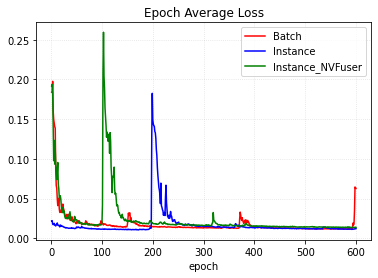

In [56]:
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(max_epochs)]
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, loss_dict['orig'], label='Batch', color="red")
plt.plot(x, loss_dict['instance'], label='Instance', color="blue")
plt.plot(x, loss_dict['instance_nvfuser'], label='Instance_NVFuser', color="green")
plt.legend()

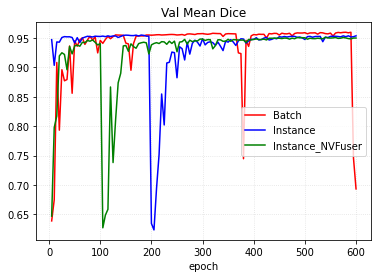

In [57]:
plt.title("Val Mean Dice")
x = [(i + 1) * 5 for i in range(max_epochs // 5)]
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, metric_dict['orig'], label='Batch', color="red")
plt.plot(x, metric_dict['instance'], label='Instance', color="blue")
plt.plot(x, metric_dict['instance_nvfuser'], label='Instance_NVFuser', color="green")
plt.legend()

In [14]:
def func():
    load_ops, load_time = 0, 0
    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

    dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

    if fast:
        # SGD prefer to much bigger learning rate
        optimizer = SGD(
            model.parameters(),
            lr=learning_rate * 1000,
            momentum=0.9,
            weight_decay=0.00004,
        )
        scaler = torch.cuda.amp.GradScaler()
    else:
        optimizer = Adam(model.parameters(), learning_rate)

    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [[], [], []]
    epoch_loss_values = []
    metric_values = []
    epoch_times = []
    total_start = time.time()

    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")

        # profiling: full epoch
        with nvtx.annotate("epoch", color="red") if profiling else no_profiling:
            model.train()
            epoch_loss = 0
            train_loader_iterator = iter(train_loader)

            # using step instead of iterate through train_loader directly to track data loading time
            # steps are 1-indexed for printing and calculation purposes
            for step in range(1, len(train_loader) + 1):
                step_start = time.time()

                # profiling: train dataload
                with nvtx.annotate("dataload", color="red") if profiling else no_profiling:
                    # rng_train_dataload = nvtx.start_range(message="dataload", color="red")
                    load_start = time.time()
                    batch_data = next(train_loader_iterator)
                    load_time += time.time() - load_start
                    load_ops += 1
                    inputs, labels = (
                        batch_data["image"].to(device),
                        batch_data["label"].to(device),
                    )

                optimizer.zero_grad()
                # set AMP for MONAI training
                # profiling: forward
                with nvtx.annotate("forward", color="green") if profiling else no_profiling:
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = loss_function(outputs, labels)

                # profiling: backward
                with nvtx.annotate("backward", color="blue") if profiling else no_profiling:
                    scaler.scale(loss).backward()

                # profiling: update
                with nvtx.annotate("update", color="yellow") if profiling else no_profiling:
                    scaler.step(optimizer)
                    scaler.update()
                epoch_loss += loss.item()
                epoch_len = math.ceil(len(train_ds) / train_loader.batch_size)
                print(
                    f"{step}/{epoch_len}, train_loss: {loss.item():.4f}"
                    f" step time: {(time.time() - step_start):.4f}"
                )
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            if (epoch + 1) % val_interval == 0:
                model.eval()
                with torch.no_grad():
                    val_loader_iterator = iter(val_loader)

                    for val_step in range(len(val_loader)):
                        # profiling: val dataload
                        with nvtx.annotate("dataload", color="red") if profiling else no_profiling:
                            val_data = next(val_loader_iterator)
                            val_inputs, val_labels = (
                                val_data["image"].to(device),
                                val_data["label"].to(device),
                            )

                        roi_size = (160, 160, 160)
                        sw_batch_size = 4

                        # profiling: sliding window
                        with nvtx.annotate("sliding window", color="green") if profiling else no_profiling:
                            # set AMP for MONAI validation
                            if fast:
                                with torch.cuda.amp.autocast():
                                    val_outputs = sliding_window_inference(
                                        val_inputs, roi_size, sw_batch_size, model
                                    )
                            else:
                                val_outputs = sliding_window_inference(
                                    val_inputs, roi_size, sw_batch_size, model
                                )

                        # profiling: decollate batch
                        with nvtx.annotate("decollate batch", color="blue") if profiling else no_profiling:
                            val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                            val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                        # profiling: compute metric
                        with nvtx.annotate("compute metric", color="yellow") if profiling else no_profiling:
                            dice_metric(y_pred=val_outputs, y=val_labels)

                    metric = dice_metric.aggregate().item()
                    dice_metric.reset()
                    metric_values.append(metric)
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        best_metrics_epochs_and_time[0].append(best_metric)
                        best_metrics_epochs_and_time[1].append(best_metric_epoch)
                        best_metrics_epochs_and_time[2].append(
                            time.time() - total_start
                        )
                        torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pt"))
                        print("saved new best metric model")
                    print(
                        f"current epoch: {epoch + 1} current"
                        f" mean dice: {metric:.4f}"
                        f" best mean dice: {best_metric:.4f}"
                        f" at epoch: {best_metric_epoch}"
                    )

        print(
            f"time consuming of epoch {epoch + 1} is:"
            f" {(time.time() - epoch_start):.4f}"
        )
        epoch_times.append(time.time() - epoch_start)

    total_time = time.time() - total_start
    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {total_time:.4f}"
    )
    
    return total_time, epoch_loss_values, metric_values, load_time / load_ops

## Profiling visualization

Here we give a brief overview of key observations from the `nsys-rep` output file when opened in Nsight systems (2022.2.1).

In the GUI, select File -> Open -> output_base.nsys-rep. Here is a sample of the display:

![png](figures/nsys-all-annotated.png)
- To get a better view of details, you can left-click and select a horizontal section, then right-click and "Zoom into Selection." To return, right-click and select "Reset Zoom."
- Sections B and C show training before and after acceleration (when fast=False and fast=True, accordingly). Clearly, MONAI optimized training is much faster than regular PyTorch training. B and C both contain two rows; the upper row shows per-epoch time, and the lower row shows per-action time (user-defined, like dataloading, forward, backward, etc.).
- Section A shows GPU utilization, where the height of the blue bars represents utilization rate. Regular PyTorch training shows sporadic and varying levels of GPU utilization, while MONAI optimized training shows consistent and high levels of GPU utilization.

Expanding one more thread in the lower left corner and several more threads below \[4648\], we see the following:

![png](figures/nsys-transforms-annotated.png)

Sections D and E both include information on the transform chain.
- Section E: In MONAI optimized training, results of all transforms in the chain until the first randomized transform is stored to prevent repeated operations. This explains why E is chronologically before any of the training epochs in the figure.
- Section D: In regular PyTorch training, CacheDataset is not in use, and the transform chain is performed every epoch on all data used.

Here is the display of the transform chain when zoomed in:
![png](figures/nsys-fast-transform.png)

And a display of one training epoch of MONAI optimized training when zoomed in:
![png](figures/nsys-epoch-short.png)
Notice that the per-epoch time is >20 times faster than the regular PyTorch training.

## Plot training loss and validation metrics

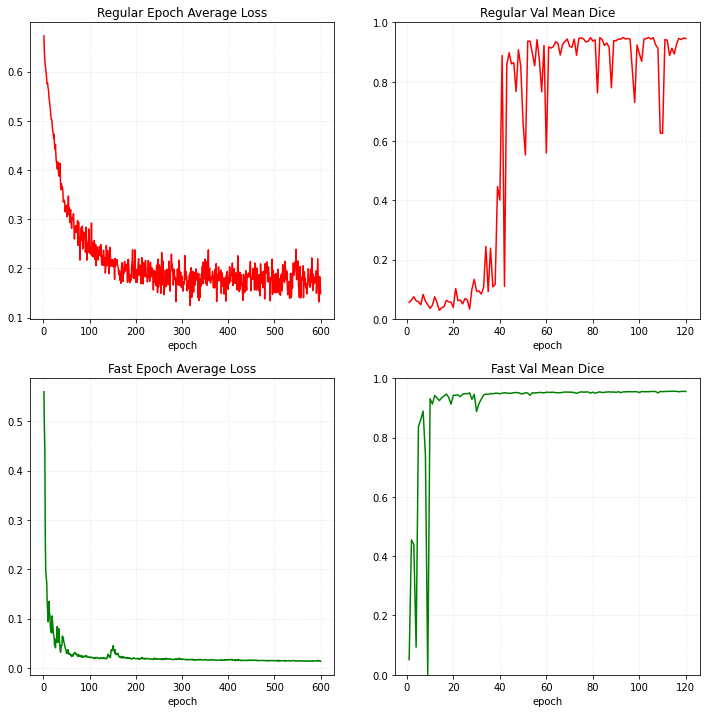

In [12]:
if not profiling:
    plt.figure("train", (12, 12))
    plt.subplot(2, 2, 1)
    plt.title("Regular Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.grid(alpha=0.4, linestyle=":")
    plt.plot(x, y, color="red")

    plt.subplot(2, 2, 2)
    plt.title("Regular Val Mean Dice")
    x = [(i + 1) * 5 for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.ylim(0, 1)
    plt.grid(alpha=0.4, linestyle=":")
    plt.plot(x, y, color="red")

    plt.subplot(2, 2, 3)
    plt.title("Fast Epoch Average Loss")
    x = [i + 1 for i in range(len(m_epoch_loss_values))]
    y = m_epoch_loss_values
    plt.xlabel("epoch")
    plt.grid(alpha=0.4, linestyle=":")
    plt.plot(x, y, color="green")

    plt.subplot(2, 2, 4)
    plt.title("Fast Val Mean Dice")
    x = [(i + 1) * 5 for i in range(len(m_metric_values))]
    y = m_metric_values
    plt.xlabel("epoch")
    plt.ylim(0, 1)
    plt.grid(alpha=0.4, linestyle=":")
    plt.plot(x, y, color="green")
    plt.savefig("outputs/loss_dice_comparison.png")

## Plot total time and every epoch time

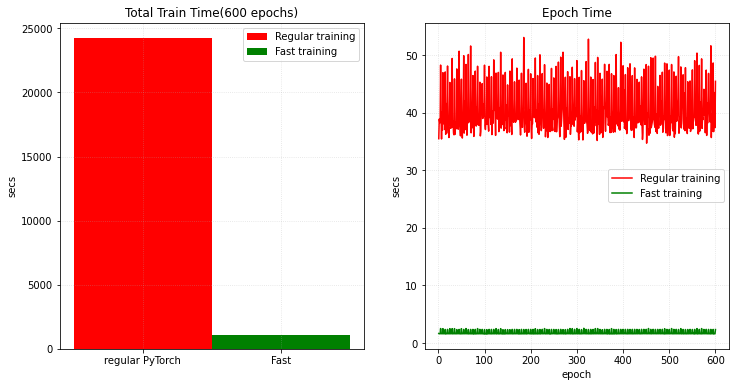

In [13]:
if not profiling:
    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Total Train Time(600 epochs)")
    plt.bar(
        "regular PyTorch", total_time, 1, label="Regular training", color="red"
    )
    plt.bar("Fast", m_total_time, 1, label="Fast training", color="green")
    plt.ylabel("secs")
    plt.grid(alpha=0.4, linestyle=":")
    plt.legend(loc="best")

    plt.subplot(1, 2, 2)
    plt.title("Epoch Time")
    x = [i + 1 for i in range(len(epoch_times))]
    plt.xlabel("epoch")
    plt.ylabel("secs")
    plt.plot(x, epoch_times, label="Regular training", color="red")
    plt.plot(x, m_epoch_times, label="Fast training", color="green")
    plt.grid(alpha=0.4, linestyle=":")
    plt.legend(loc="best")
    plt.savefig("outputs/total_epoch_time_comparison.png")

## Plot total time to achieve metrics

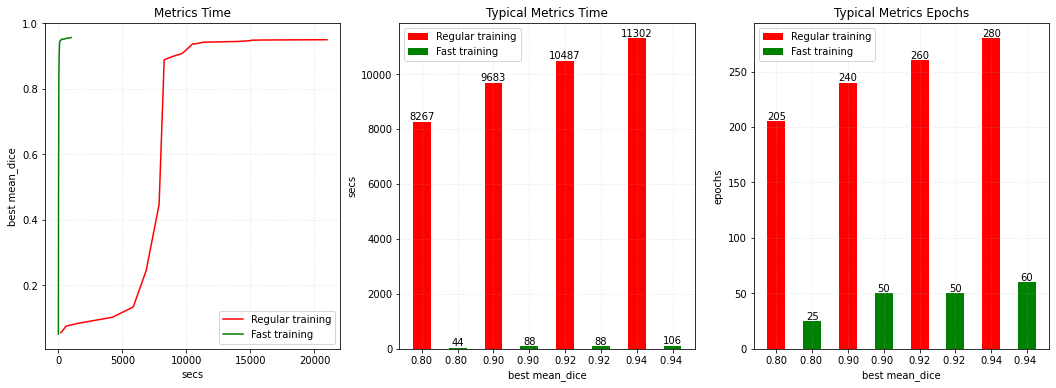

In [14]:
def get_best_metric_time(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if round(v, 4) >= threshold:
            return best_values[2][i]
    return -1


def get_best_metric_epochs(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if round(v, 4) >= threshold:
            return best_values[1][i]
    return -1


def get_label(index):
    if index == 0:
        return "Regular training"
    elif index == 1:
        return "Fast training"
    else:
        return None


if not profiling:
    plt.figure("train", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("Metrics Time")
    plt.xlabel("secs")
    plt.ylabel("best mean_dice")
    plt.plot(best[2], best[0], label="Regular training", color="red")
    plt.plot(m_best[2], m_best[0], label="Fast training", color="green")
    plt.grid(alpha=0.4, linestyle=":")
    plt.legend(loc="best")

    plt.subplot(1, 3, 2)
    plt.title("Typical Metrics Time")
    plt.xlabel("best mean_dice")
    plt.ylabel("secs")
    labels = ["0.80", "0.80 ", "0.90", "0.90 ", "0.92", "0.92 ", "0.94", "0.94 "]
    x_values = [0.8, 0.8, 0.9, 0.9, 0.92, 0.92, 0.94, 0.94]
    for i, (l, x) in enumerate(zip(labels, x_values)):
        value = int(get_best_metric_time(x, best if i % 2 == 0 else m_best))
        color = "red" if i % 2 == 0 else "green"
        plt.bar(l, value, 0.5, label=get_label(i), color=color)
        plt.text(l, value, "%s" % value, ha="center", va="bottom")
    plt.grid(alpha=0.4, linestyle=":")
    plt.legend(loc="best")

    plt.subplot(1, 3, 3)
    plt.title("Typical Metrics Epochs")
    plt.xlabel("best mean_dice")
    plt.ylabel("epochs")
    for i, (l, x) in enumerate(zip(labels, x_values)):
        value = int(get_best_metric_epochs(x, best if i % 2 == 0 else m_best))
        color = "red" if i % 2 == 0 else "green"
        plt.bar(l, value, 0.5, label=get_label(i), color=color)
        plt.text(l, value, "%s" % value, ha="center", va="bottom")
    plt.grid(alpha=0.4, linestyle=":")
    plt.legend(loc="best")
    plt.savefig("outputs/metric_time_epochs.png")

## Cleanup data directory

Remove directory if a temporary was used.

In [15]:
if directory is None:
    shutil.rmtree(root_dir)

[<sup id="fn1">1</sup>](#fn1-back) Acknowledgement: This usage is inspired by [Conditional with statement in Python](https://stackoverflow.com/a/68682614) by [Lucas Vasquez](https://stackoverflow.com/users/10712525/lucas-vazquez), used with adaptations under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/), accessed June 14, 2022.</span>